In [ ]:
install.packages("deSolve")
install.packages("minpack.lm")
install.packages("gridExtra")
install.packages("igraph")
install.packages("sets")
install.packages("purrr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)
library(deSolve)
library(minpack.lm)
library(gridExtra)
library(igraph)
library(sets)
library(purrr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘sets’


The following object is masked from ‘package:igraph’:

    %>%



Attaching package: ‘purrr’


The following object is masked from ‘package:sets’:

    %>%


The following objects are masked from ‘package:igraph’:

    compose, simplify




## LANGUAGE DYNAMICS COMPETITION

# MODEL BUILDING

We consider a model of $ N = L \times L$ nodes in form of a lattice structure.

In [ ]:
lattice_graph <- function(N, languages) {
    L <- as.integer(sqrt(N))

    initial_languages <- sample(languages, N, replace=TRUE)
    g <- make_lattice(length =L, dim=2)
    V(g)$language <- initial_languages
    return(g)
}

## ABRAMS -STROGATZ MODEL

Transition probabilities are:

$$ p_{i, A -> B} = \frac 1 2 \sigma_i ^B , ~~~ p_{i, B -> A} = \frac 1 2 \sigma_i ^A  $$

In [ ]:
prob_AS <- function(node_index, neighbors_index, g, a, s) {
    node <- V(g)$language[node_index]

    if (length(neighbors_index)==0) {
      return (as.integer(c("A", "B")==node))
    }


    if(node=="A") {
        prob_B <- (1 - s)* ((sum(V(g)$language[neighbors_index]=="B") / length(neighbors_index))**a)
        prob_A <- 1 - prob_B
    } else {
        prob_A <- s* ((sum(V(g)$language[neighbors_index]=="A") / length(neighbors_index))**a)
        prob_B <- 1 - prob_A
    }
    return(c(prob_A, prob_B))
}



In [ ]:
AbramsStrogatz<- function(g, epochs, a=1, s=0.5) {



    N <- length(V(g))

    interface_density <- c()

    interval <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))
    iteration <- 1


    for (i in 1:epochs) {
        random_node <- sample(1:N, 1, replace=TRUE)

        node_neighbors <- neighbors(graph = g, v = random_node)

        probabilities <- prob_AS(random_node, node_neighbors, g, a=a, s=s)

        rand_num <- sample(c(1, 2), size=1, replace = TRUE, prob =probabilities)

        if (rand_num ==1) {
            V(g)$language[random_node] = "A"
        } else {
            V(g)$language[random_node] = "B"
        }



        if (i %in% interval) {
            interface_density[iteration] <- sum(sapply(1:N, function(j) sum(V(g)$language[j] != V(g)$language[neighbors(graph = g, v = j)])))/N
            iteration <- iteration + 1
        }


    }
    return(list(g=g, interface_density=interface_density))
}


### Bilingual MODEL

Transition probabilities are:

$$ p_{i, A-> AB} = \frac 1 2 \sigma_i ^B  ~~~  p_{i, B-> AB} = \frac 1 2 \sigma_i ^A $$

$$ p_{i, AB-> B} = \frac 1 2 (1 - \sigma_i ^A)  ~~~  p_{i, AB-> A} = \frac 1 2 (1 - \sigma_i ^B) $$


In [ ]:
map_color <- function(vertex) {
    if (vertex =="A") {
        return("red")
    } else if (vertex=="B") {
        return("blue")
    } else {
        return("orange")
    }
}


In [ ]:
prob_Bi <- function(node_index, neighbors_index, g) {


    node <- V(g)$language[node_index]

    if (length(neighbors_index)==0) {
      return (as.integer(c("A", "B", "AB")==node))
    }


    if (node=="AB") {
        prob_A <- 0.5*(1 - sum(V(g)$language[neighbors_index] == "B") / length(neighbors_index))
        prob_B <- 0.5*(1 - sum(V(g)$language[neighbors_index] == "A") / length(neighbors_index))
        prob_AB <- 1 - prob_A - prob_B
    }
    else if(node=="A") {
        prob_AB <- 0.5*sum(V(g)$language[neighbors_index] == "B") / length(neighbors_index)
        prob_B <- 0
        prob_A <- 1 - prob_AB
    } else if(node=="B"){
        prob_AB <- 0.5*sum(V(g)$language[neighbors_index] == "A") / length(neighbors_index)
        prob_A <- 0
        prob_B <- 1 - prob_AB
    }
    return(c(prob_A, prob_B, prob_AB))
}


In [ ]:
Billingual <- function(g, epochs) {

    N <- length(V(g))

    interface_density <- c()

    interval <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))
    iteration <- 1

    for (i in 1:epochs) {
        random_node <- sample(1:N, 1, replace=TRUE)

        node_neighbors <- neighbors(graph = g, v = random_node)

        probabilities <- prob_Bi(random_node, node_neighbors, g)

        rand_num <- sample(c(1, 2, 3), size=1, replace = TRUE, prob =probabilities)


        if (rand_num ==1) {
            V(g)$language[random_node] = "A"

        } else if (rand_num==2) {
            V(g)$language[random_node] = "B"
        } else {
            V(g)$language[random_node] = "AB"
        }


        if (i %in% interval) {
            interface_density[iteration] <- sum(sapply(1:N, function(j) sum(V(g)$language[j] != V(g)$language[neighbors(graph = g, v = j)])))/N
            iteration <- iteration + 1

        }

    }

    return(list(g=g, interface_density=interface_density))

}



### MODEL EVOLUTION

In [ ]:
N <- 400
languages <- c("A", "B")

g_AS <- lattice_graph(N, languages)

languages <- c("A", "AB", "B")

g_Bi <- lattice_graph(N, languages)



In [ ]:
plot_graph <- function (g) {
  plot(g, layout = layout.grid(g), vertex.size=10, vertex.shape="circle",
  vertex.color = sapply(V(g)$language, map_color), vertex.label=NA)
}


In [ ]:

results_AS100 <- AbramsStrogatz(g_AS, epochs = 100)
results_Bi100 <- Billingual(g_Bi, epochs = 100)

results_AS2500 <- AbramsStrogatz(g_AS, epochs = 2500)
results_Bi2500 <- Billingual(g_Bi, epochs = 2500)

results_AS50000 <- AbramsStrogatz(g_AS, epochs = 50000)
results_Bi50000 <- Billingual(g_Bi, epochs = 50000)

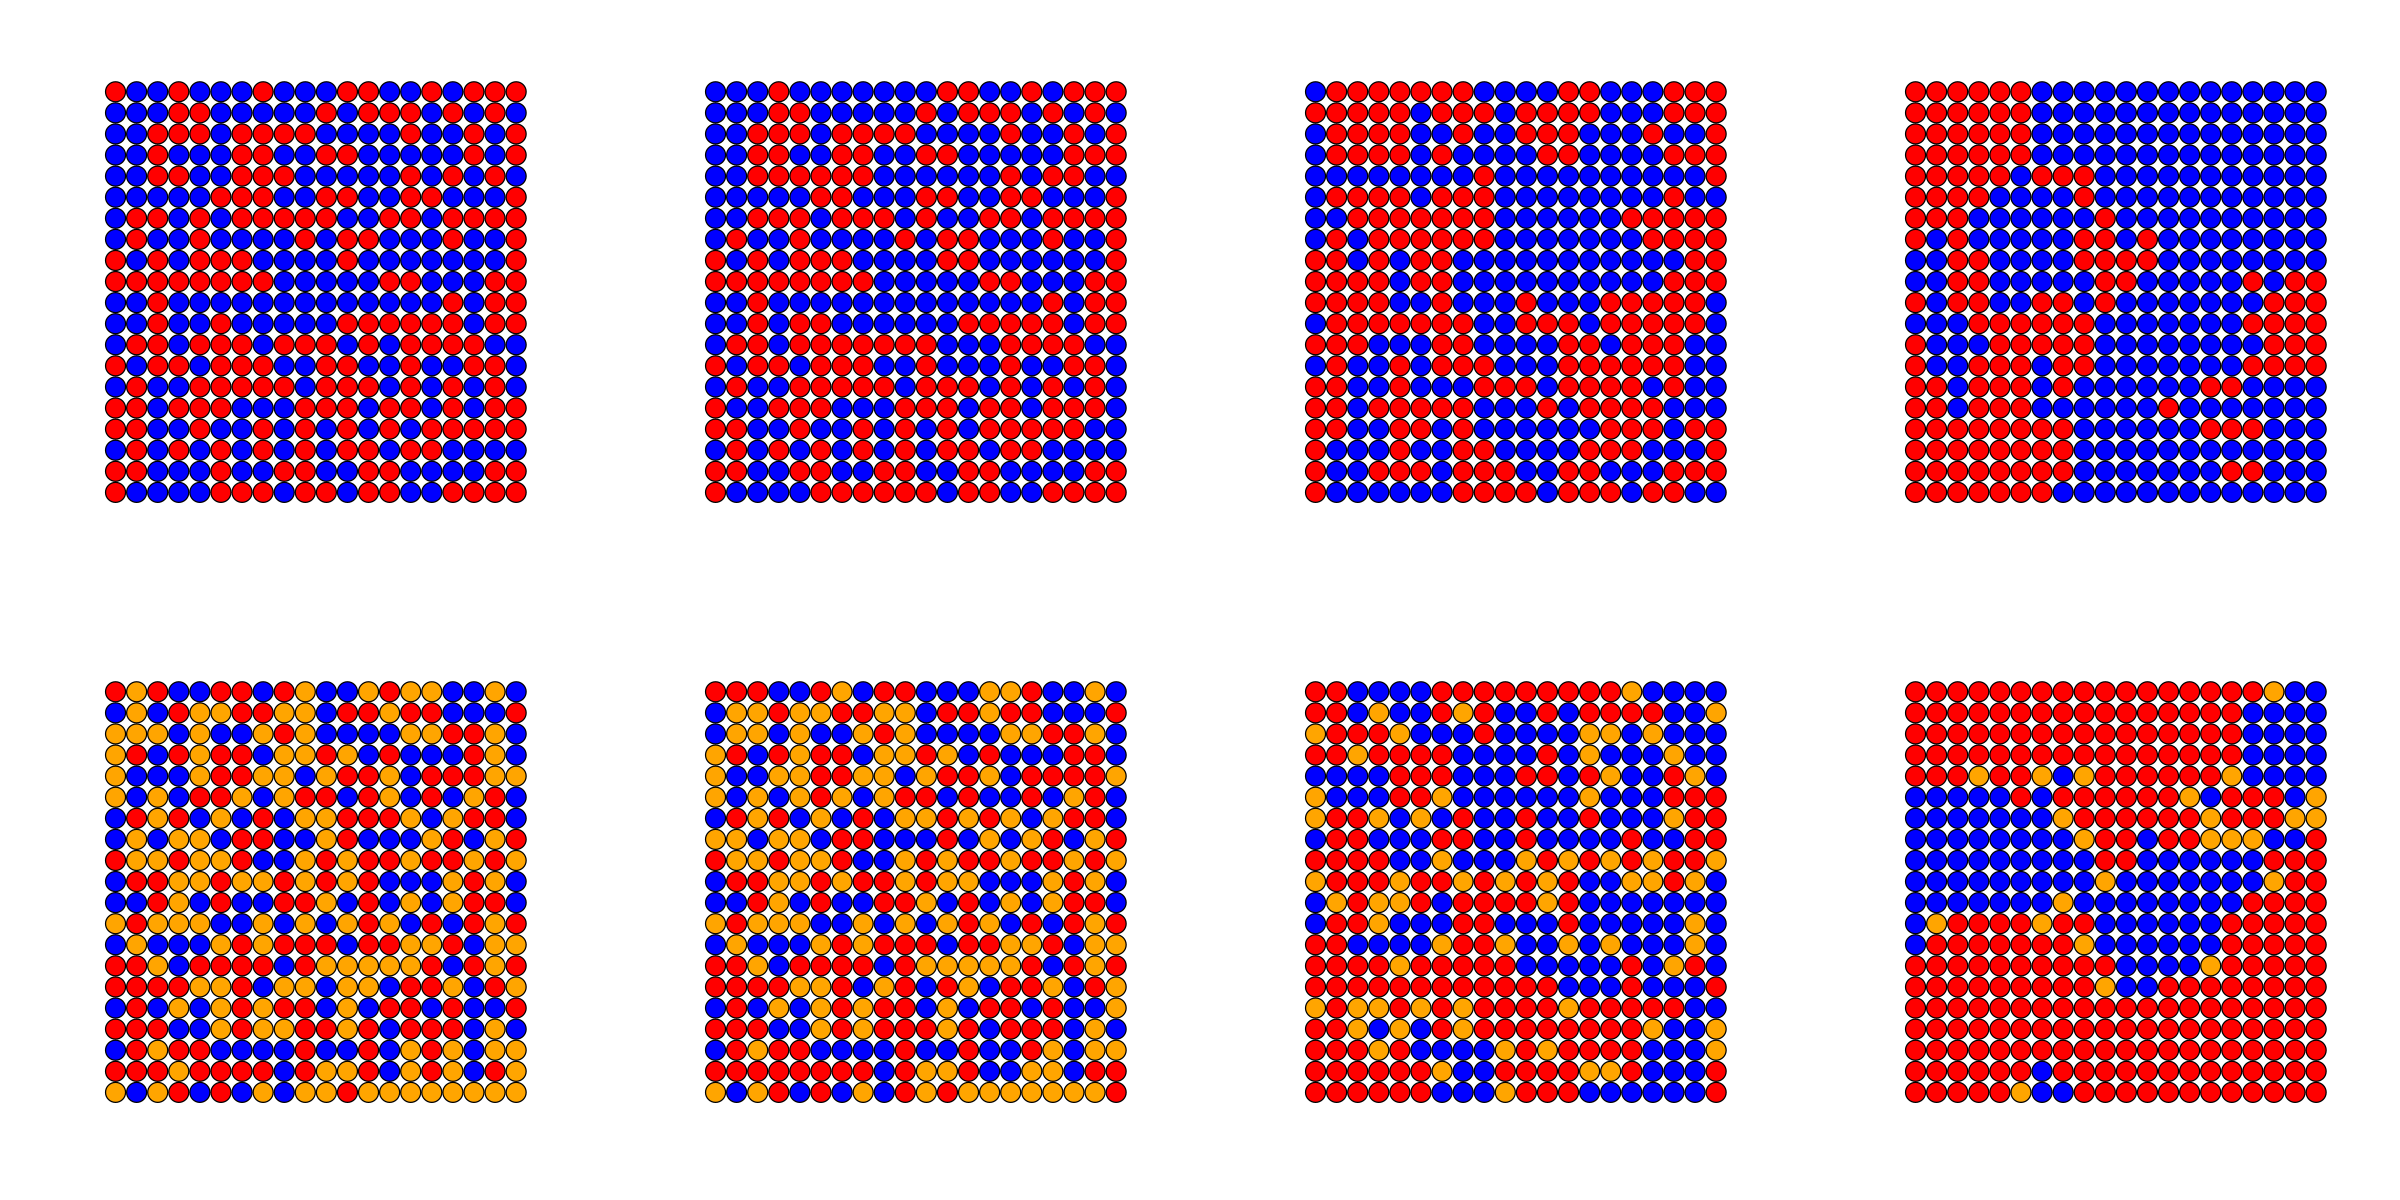

In [ ]:
par(mfrow=c(2, 4))
options(repr.plot.width=20, repr.plot.height=10)

plot_graph(g_AS)
plot_graph(results_AS100$g)
plot_graph(results_AS2500$g)
plot_graph(results_AS50000$g)

plot_graph(g_Bi)
plot_graph(results_Bi100$g)
plot_graph(results_Bi2500$g)
plot_graph(results_Bi50000$g)


## MODEL STUDY

In order to characterize the growth of linguistic domains we can use $\rho$ which is defined as the number of links joining agents in different state by the number of total links.

### Number of Nodes N

We can now try to see if by changing the number of nodes $N$ the behaviour of the model changes.

In [ ]:
avg_rho<- function(N, iterations, epochs, languages, model, p=0) {

  avg_interface <- list()
  for (i in 1:iterations) {
    g <- lattice_graph(N=N, languages = languages)
    results <- model(g, epochs = epochs)
    avg_interface[[i]] <- results$interface_density
  }
  average_results <- sapply(1:length(avg_interface[[1]]), function(i) mean(sapply(avg_interface, function(x) x[i])))
  return(unlist(average_results))
}



In [ ]:
# DO NOT RUN. TAKES A LOT OF TIME (USE THE CSV FILES INSTEAD)

epochs <- 50000
iterations <- 25

avg_densityN64_AS <- avg_rho(N=64, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_densityN100_AS <- avg_rho(N=100, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_densityN225_AS <- avg_rho(N=225, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_densityN400_AS <- avg_rho(N=400, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_densityN900_AS <- avg_rho(N=900, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)

avg_densityN64_Bi <- avg_rho(N=64, iterations = iterations, epochs=epochs, languages = c("A", "AB", "B"), Billingual)
avg_densityN100_Bi <- avg_rho(N=100, iterations = iterations, epochs=epochs, languages = c("A", "AB", "B"), Billingual)
avg_densityN225_Bi <- avg_rho(N=225, iterations = iterations, epochs=epochs, languages = c("A", "AB", "B"), Billingual)
avg_densityN400_Bi <- avg_rho(N=400, iterations = iterations, epochs=epochs, languages = c("A", "AB", "B"), Billingual)
avg_densityN900_Bi <- avg_rho(N=900, iterations = iterations, epochs=epochs, languages = c("A", "AB", "B"), Billingual)


In [ ]:
average_interface_data <- data.frame(N64_AS = avg_densityN64_AS, N100_AS = avg_densityN100_AS, N225_AS = avg_densityN225_AS,
N400_AS = avg_densityN400_AS, N900_AS = avg_densityN900_AS, N64_Bi = avg_densityN64_Bi,
N100_Bi = avg_densityN100_Bi, N225_Bi = avg_densityN225_Bi, N400_Bi = avg_densityN400_Bi, N900_Bi = avg_densityN900_Bi)

write.csv(average_interface_data, file = "changeN.csv", row.names=FALSE)

In [ ]:
data <- read.csv("changeN.csv")

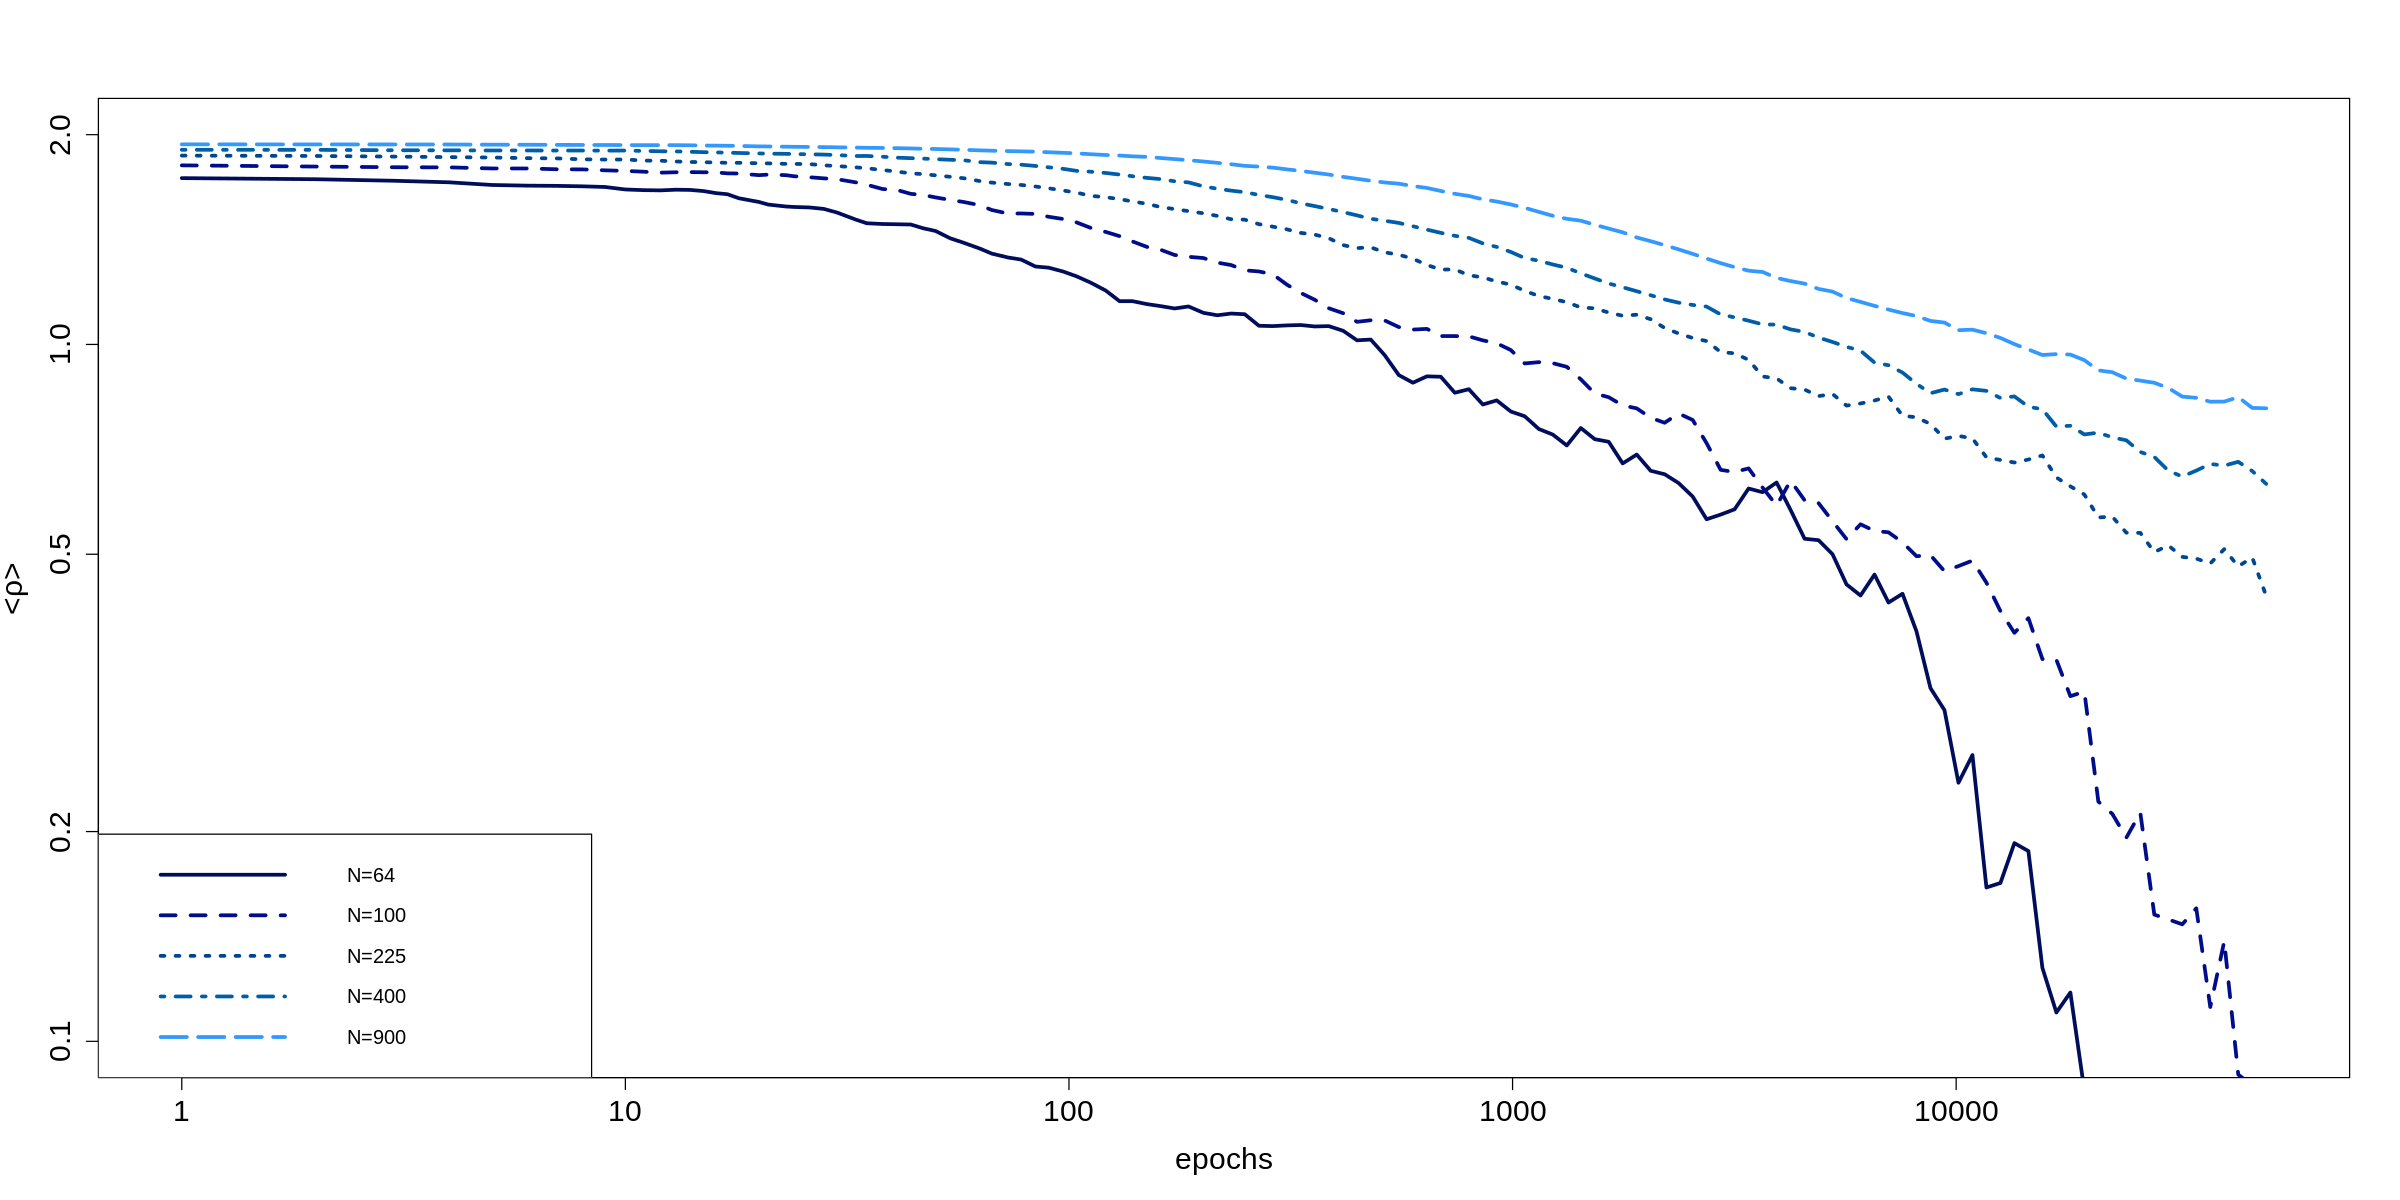

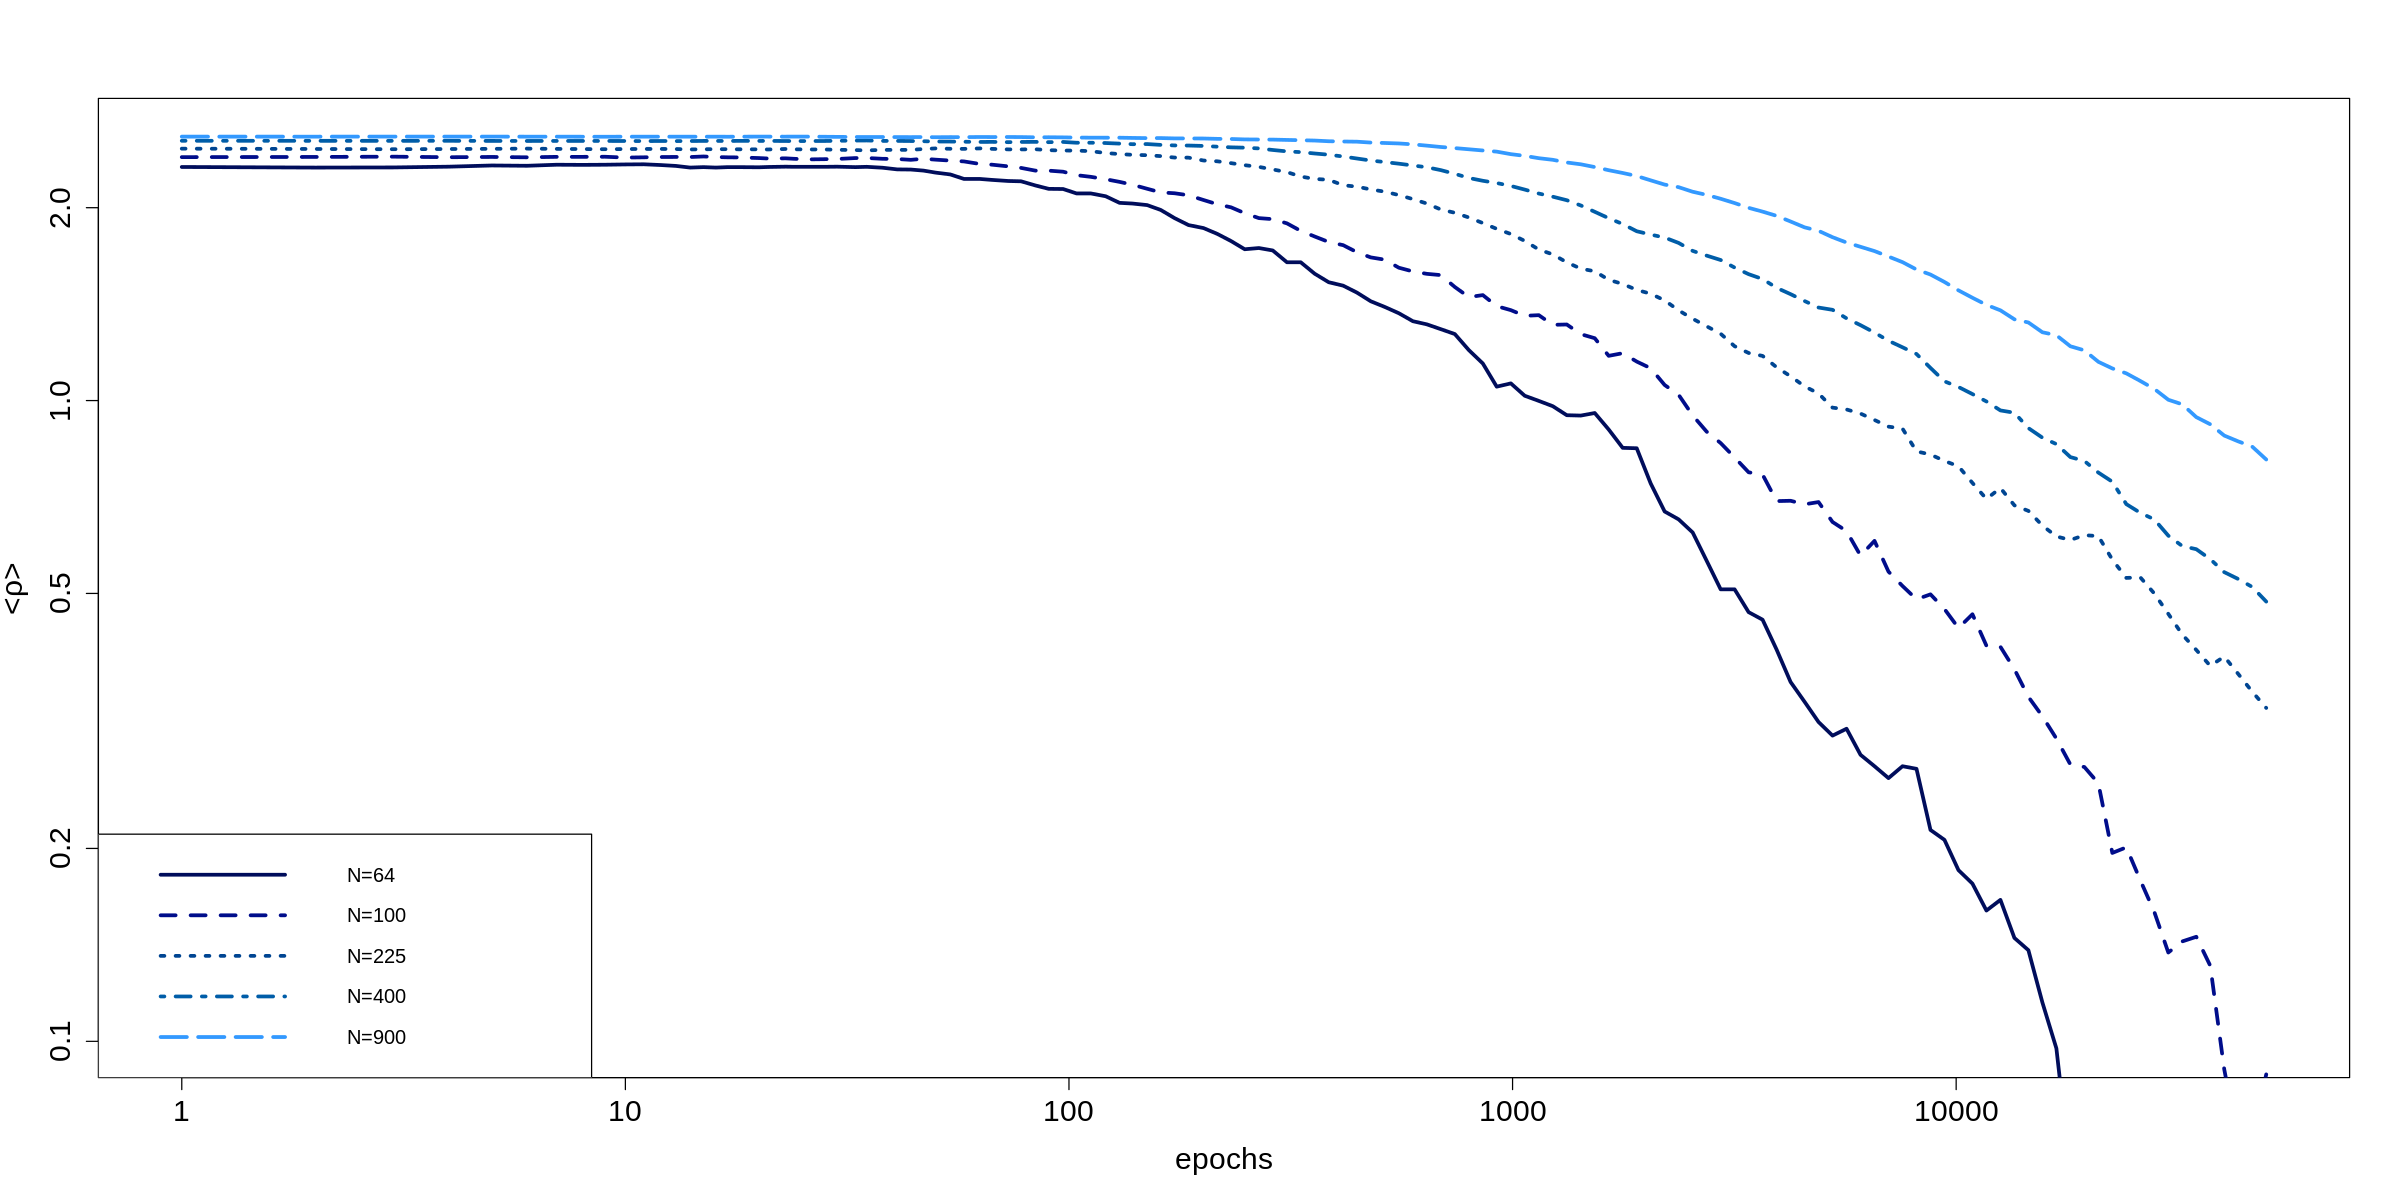

In [ ]:
epochs <- 50000
x <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))

#png("AS_change_N.png", width = 600, height = 600)

plot(x[data$N64_AS>0], data$N64_AS[data$N64_AS>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$N64_AS>0], data$N64_AS[data$N64_AS>0], lwd=3, lty=1, col="#000D5B")
lines(x[data$N100_AS>0], data$N100_AS[data$N100_AS>0], lwd=3, lty=2, col= "#000D8B")
lines(x[data$N225_AS>0], data$N225_AS[data$N225_AS>0], lwd=3, lty=3, col= "#004592")
lines(x[data$N400_AS>0], data$N400_AS[data$N400_AS>0], lwd=3, lty=4, col= "#005DA8")
lines(x[data$N900_AS>0], data$N900_AS[data$N900_AS>0], lwd=3, lty=5, col= "#3399FF")

legend("bottomleft", legend = c("N=64", "N=100", "N=225", "N=400", "N=900"),
       col = c("#000D5B", "#000D8B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4, 5))

#dev.off()

#png("Bi_change_N.png", width = 600, height = 600)

plot(x[data$N64_Bi>0], data$N64_Bi[data$N64_Bi>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2.6), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$N64_Bi>0], data$N64_Bi[data$N64_Bi>0], lwd=3, lty=1, col="#000D5B")
lines(x[data$N100_Bi>0], data$N100_Bi[data$N100_Bi>0], lwd=3, lty=2, col= "#000D8B")
lines(x[data$N225_Bi>0], data$N225_Bi[data$N225_Bi>0], lwd=3, lty=3, col= "#004592")
lines(x[data$N400_Bi>0], data$N400_Bi[data$N400_Bi>0], lwd=3, lty=4, col= "#005DA8")
lines(x[data$N900_Bi>0], data$N900_Bi[data$N900_Bi>0], lwd=3, lty=5, col= "#3399FF")

legend("bottomleft", legend = c("N=64", "N=100", "N=225", "N=400", "N=900"),
       col = c("#000D5B", "#000D8B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4, 5))

#dev.off()

We can realize that the data follows a power-law distribution as:

$$ <\rho> = t^{-\gamma} $$

Where t is the number of epochs and $\gamma$ is a parameter that indicates how fast the decay is.

In [ ]:
###
data <- cbind(x, data)

gamma_N64_AS <- as.numeric(-coef(lm(log(N64_AS[N64_AS > 0]) ~ log(x[N64_AS > 0]), data=data))[2])
gamma_N100_AS <-as.numeric(-coef(lm(log(N100_AS[N100_AS > 0]) ~ log(x[N100_AS > 0]), data=data))[2])
gamma_N225_AS <-as.numeric(-coef(lm(log(N225_AS[N225_AS > 0]) ~ log(x[N225_AS > 0]), data=data))[2])
gamma_N400_AS <-as.numeric(-coef(lm(log(N400_AS[N400_AS > 0]) ~ log(x[N400_AS > 0]), data=data))[2])
gamma_N900_AS <-as.numeric(-coef(lm(log(N900_AS[N900_AS > 0]) ~ log(x[N900_AS > 0]), data=data))[2])

gamma_N64_Bi <- as.numeric(-coef(lm(log(N64_Bi[N64_Bi > 0]) ~ log(x[N64_Bi > 0]), data=data))[2])
gamma_N100_Bi <-as.numeric(-coef(lm(log(N100_Bi[N100_Bi > 0]) ~ log(x[N100_Bi > 0]), data=data))[2])
gamma_N225_Bi <-as.numeric(-coef(lm(log(N225_Bi[N225_Bi > 0]) ~ log(x[N225_Bi > 0]), data=data))[2])
gamma_N400_Bi <-as.numeric(-coef(lm(log(N400_Bi[N400_Bi > 0]) ~ log(x[N400_Bi > 0]), data=data))[2])
gamma_N900_Bi <-as.numeric(-coef(lm(log(N900_Bi[N900_Bi > 0]) ~ log(x[N900_Bi > 0]), data=data))[2])

In [ ]:
coeff_gamma <- data.frame(N = c(64, 100, 225, 400, 900), Abrams_Strogatz = c(gamma_N64_AS, gamma_N100_AS, gamma_N225_AS, gamma_N400_AS, gamma_N900_AS),
Bilingual= c(gamma_N64_Bi, gamma_N100_Bi, gamma_N225_Bi, gamma_N400_Bi, gamma_N900_Bi))

head(coeff_gamma)

,N,Abrams_Strogatz,Bilingual
,<dbl>,<dbl>,<dbl>
1,64,0.29758751,0.42781067
2,100,0.25980546,0.30461328
3,225,0.14841734,0.19305475
4,400,0.12280610,0.15165247
5,900,0.09579571,0.09831941


## CHANGING THE TOPOLOGY

We can change the topology of our model in order to see how this changes as we alter the characteristic parameter of the model.

### Small World or Watts-Strogatz Model

We will build this model by rewiring one of the endpoints of each edge with probability p.

In [ ]:
small_world_graph <- function(N, languages, p) {
    L <- as.integer(sqrt(N))

    initial_languages <- sample(languages, N, replace = TRUE)
    g <- make_lattice(length = L, dim = 2)
    V(g)$language <- initial_languages

    for (e in E(g)) {
        if (runif(1) < p) {
            endpoints <- ends(g, e)
            new_endpoint <- sample(V(g), 1)
            g <- delete.edges(g, e)
            g <- add_edges(g, c(endpoints[1], new_endpoint))
        }
    }

    return(g)
}

In [ ]:
avg_rho_SmallWorld<- function(N, iterations, epochs, languages, model, p=0) {

  avg_interface <- list()
  for (i in 1:iterations) {
    g <- small_world_graph(N=N, languages = languages, p)
    results <- model(g, epochs = epochs)
    avg_interface[[i]] <- results$interface_density
  }
  average_results <- sapply(1:length(avg_interface[[1]]), function(i) mean(sapply(avg_interface, function(x) x[i])))
  return(unlist(average_results))
}




In [ ]:
# DO NOT RUN. TAKES A LOT OF TIME (USE THE CSV FILES INSTEAD)

N <- 225
iterations <- 25
epochs <- 50000

avg_densityp001_AS <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, p=0.01)
avg_densityp005_AS <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, p=0.05)
avg_densityp01_AS <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, p=0.1)
avg_densityp05_AS <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, p=0.5)
avg_densityp1_AS <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, p=1)

avg_densityp001_Bi <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A","AB", "B"), Billingual, p=0.01)
avg_densityp005_Bi <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A","AB", "B"), Billingual, p=0.05)
avg_densityp01_Bi <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A","AB", "B"), Billingual, p=0.1)
avg_densityp05_Bi <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A","AB", "B"), Billingual, p=0.5)
avg_densityp1_Bi <- avg_rho_SmallWorld(N=N, iterations = iterations, epochs=epochs, languages = c("A","AB", "B"), Billingual, p=1)

In [ ]:
avg_density_smallWorld <- data.frame(p001_AS = avg_densityp001_AS, p005_AS = avg_densityp005_AS, p01_AS = avg_densityp01_AS, p05_AS = avg_densityp05_AS,
p1_AS = avg_densityp1_AS, p001_Bi = avg_densityp001_Bi, p005_Bi = avg_densityp005_Bi, p01_Bi = avg_densityp01_Bi, p05_Bi = avg_densityp05_Bi, p1_Bi = avg_densityp1_Bi)

write.csv(avg_density_smallWorld, file = "changeP_smallWorld.csv", row.names=FALSE)

In [ ]:
data <- read.csv("changeP_smallWorld.csv")

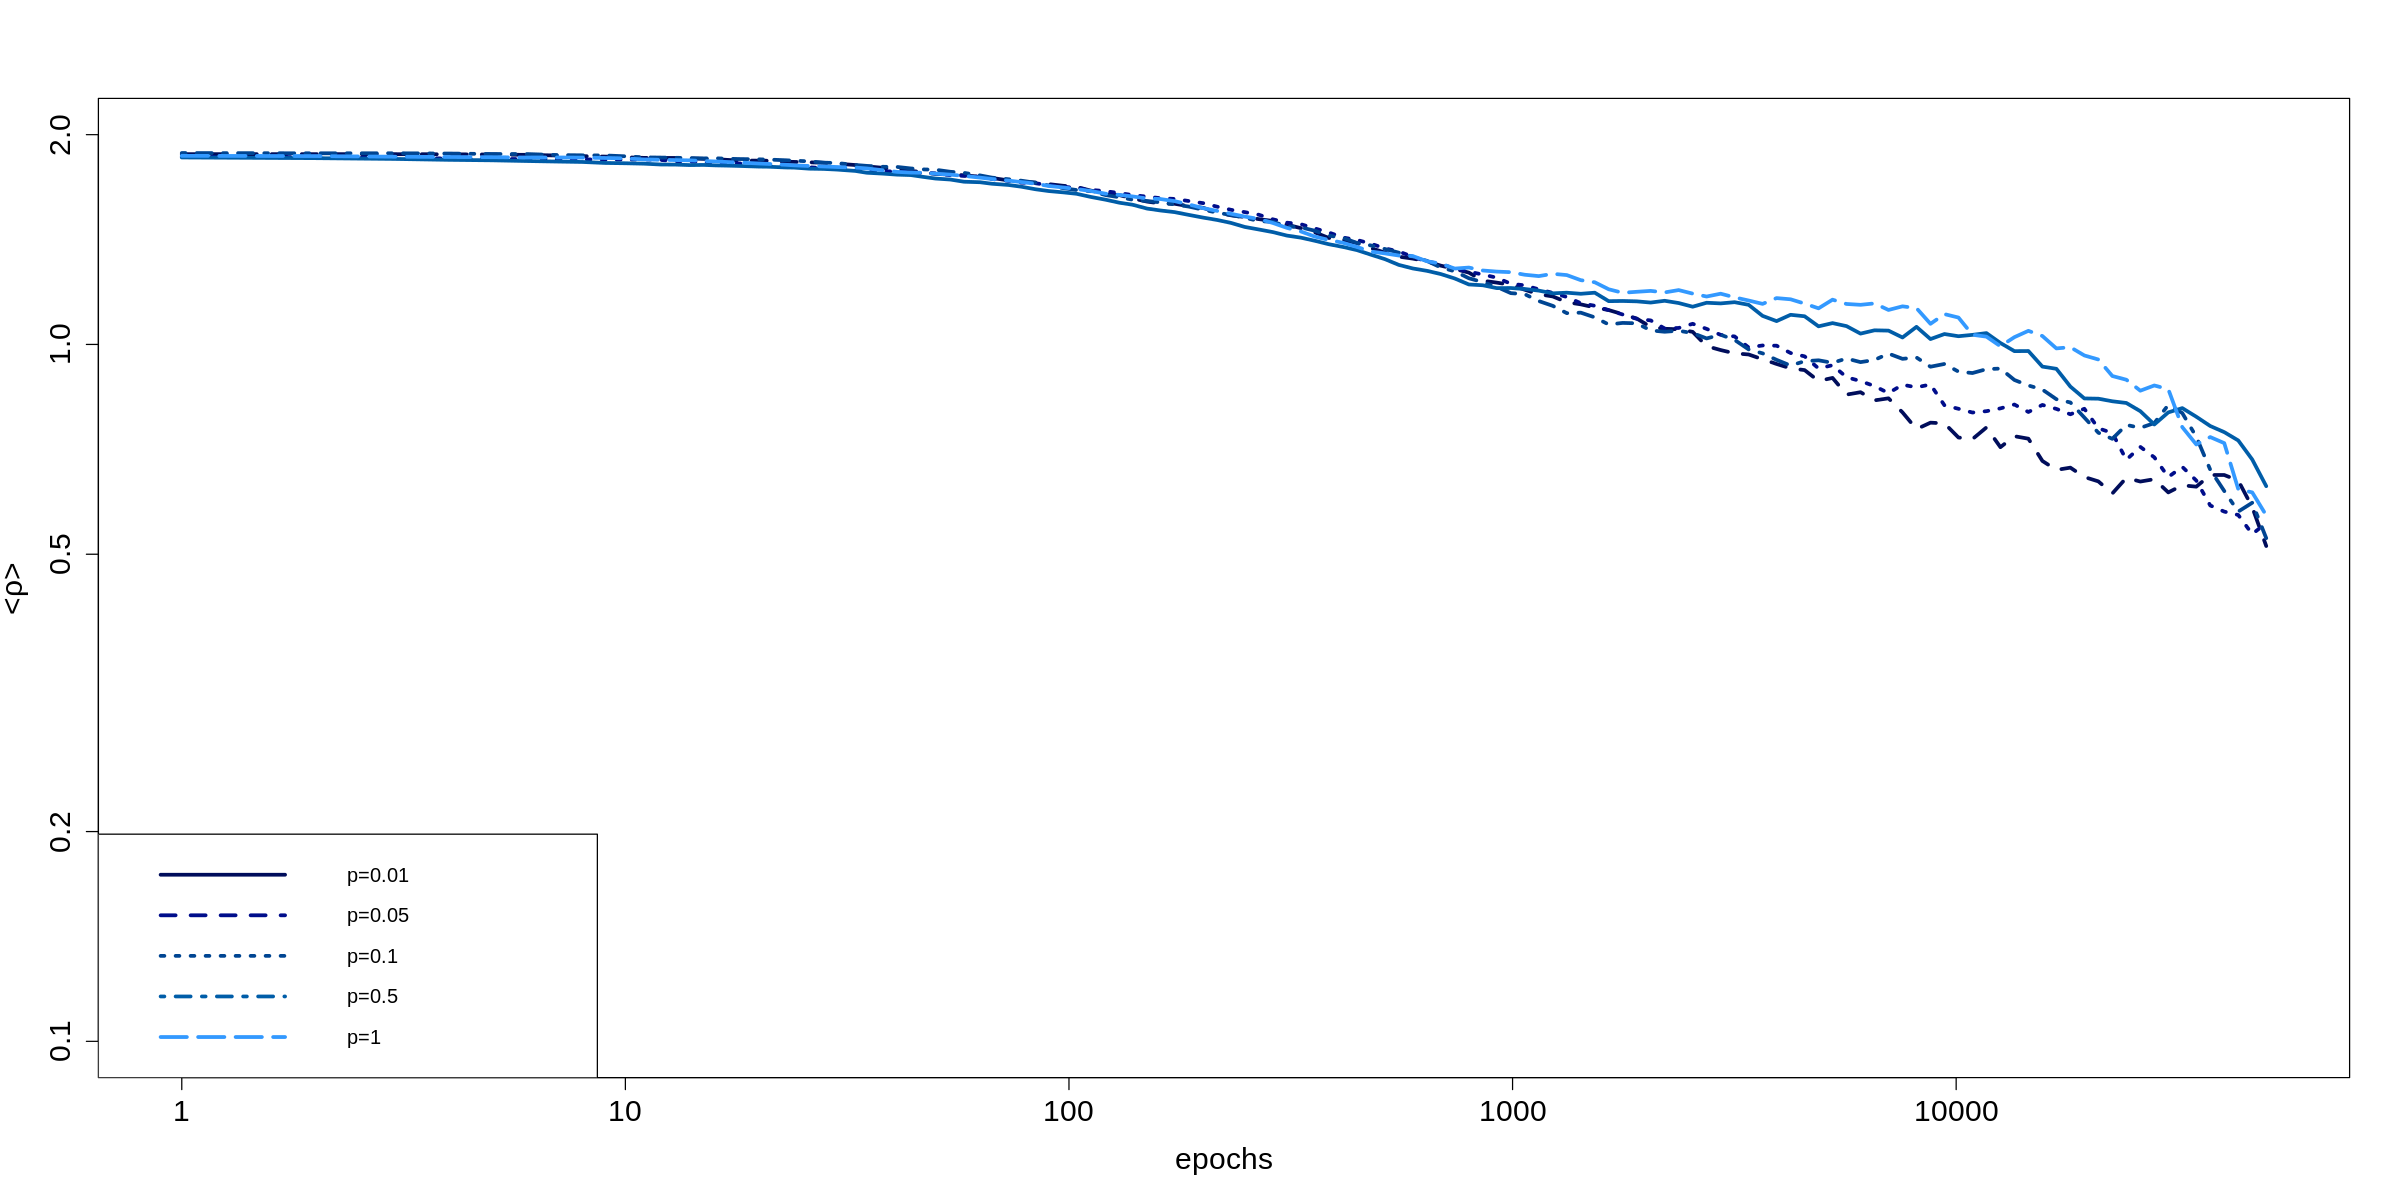

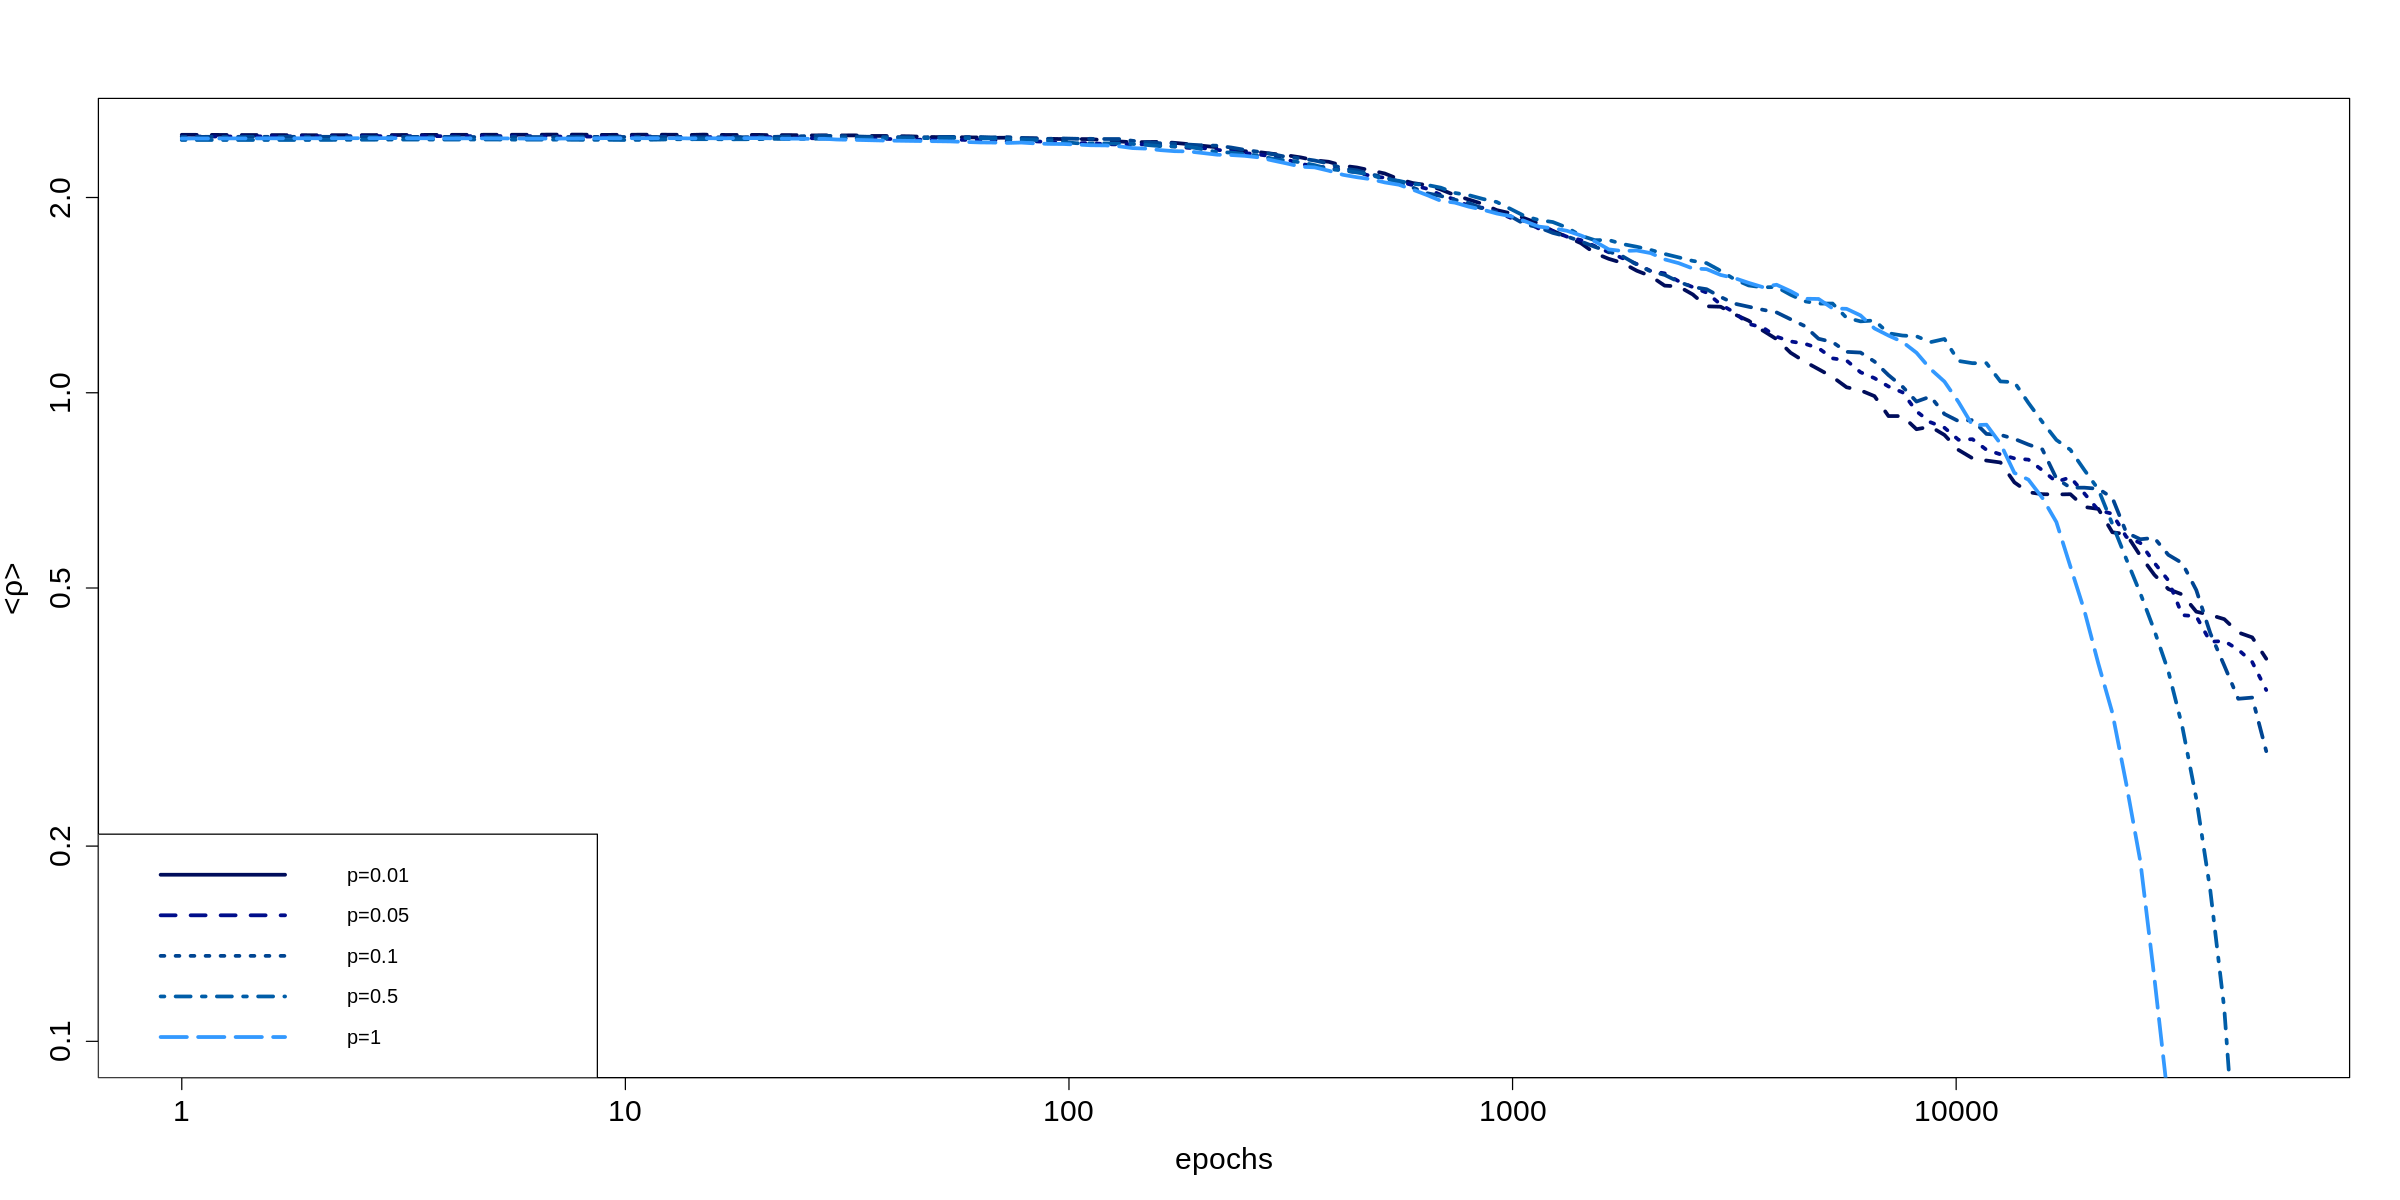

In [ ]:
epochs <- 50000
x <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))

#png("AS_change_p.png", width = 600, height = 600)

plot(x[data$p001_AS>0], data$p001_AS[data$p001_AS>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$p001_AS>0], data$p001_AS[data$p001_AS>0], lwd=3, lty=2, col= "#000D5B")
lines(x[data$p005_AS>0], data$p005_AS[data$p005_AS>0], lwd=3, lty=3, col= "#000D8B")
lines(x[data$p01_AS>0], data$p01_AS[data$p01_AS>0], lwd=3, lty=4, col= "#004592")
lines(x[data$p05_AS>0], data$p05_AS[data$p05_AS>0], lwd=3, lty=1, col="#005DA8")
lines(x[data$p1_AS>0], data$p1_AS[data$p1_AS>0], lwd=3, lty=5, col= "#3399FF")

legend("bottomleft", legend = c("p=0.01", "p=0.05", "p=0.1", "p=0.5", "p=1"),
       col = c("#000D5B", "#000D8B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4, 5))

#dev.off()

#png("Bi_change_p.png", width = 600, height = 600)

plot(x[data$p001_Bi>0], data$p001_Bi[data$p001_Bi>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2.5), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$p001_Bi>0], data$p001_Bi[data$p001_Bi>0], lwd=3, lty=2, col= "#000D5B")
lines(x[data$p005_Bi>0], data$p005_Bi[data$p005_Bi>0], lwd=3, lty=3, col= "#000D8B")
lines(x[data$p01_Bi>0], data$p01_Bi[data$p01_Bi>0], lwd=3, lty=4, col= "#004592")
lines(x[data$p05_Bi>0], data$p05_Bi[data$p05_Bi>0], lwd=3, lty=4, col= "#005DA8")
lines(x[data$p1_Bi>0], data$p1_Bi[data$p1_Bi>0], lwd=3, lty=5, col= "#3399FF")

legend("bottomleft", legend = c("p=0.01", "p=0.05", "p=0.1", "p=0.5", "p=1"),
       col = c("#000D5B", "#000D8B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4, 5))

#dev.off()

In [ ]:
data <- cbind(x, data)

gamma_p001_AS <- as.numeric(-coef(lm(log(p001_AS[p001_AS > 0]) ~ log(x[p001_AS > 0]), data=data))[2])
gamma_p005_AS <-as.numeric(-coef(lm(log(p005_AS[p005_AS > 0]) ~ log(x[p005_AS > 0]), data=data))[2])
gamma_p01_AS <-as.numeric(-coef(lm(log(p01_AS[p01_AS > 0]) ~ log(x[p01_AS > 0]), data=data))[2])
gamma_p05_AS <-as.numeric(-coef(lm(log(p05_AS[p05_AS > 0]) ~ log(x[p05_AS > 0]), data=data))[2])
gamma_p1_AS <-as.numeric(-coef(lm(log(p1_AS[p1_AS > 0]) ~ log(x[p1_AS > 0]), data=data))[2])

gamma_p001_Bi <- as.numeric(-coef(lm(log(p001_Bi[p001_Bi > 0]) ~ log(x[p001_Bi > 0]), data=data))[2])
gamma_p005_Bi <-as.numeric(-coef(lm(log(p005_Bi[p005_Bi > 0]) ~ log(x[p005_Bi > 0]), data=data))[2])
gamma_p01_Bi <-as.numeric(-coef(lm(log(p01_Bi[p01_Bi > 0]) ~ log(x[p01_Bi > 0]), data=data))[2])
gamma_p05_Bi <-as.numeric(-coef(lm(log(p05_Bi[p05_Bi > 0]) ~ log(x[p05_Bi > 0]), data=data))[2])
gamma_p1_Bi <-as.numeric(-coef(lm(log(p1_Bi[p1_Bi > 0]) ~ log(x[p1_Bi > 0]), data=data))[2])

In [ ]:
coeff_gamma_sw <- data.frame(p = c(0.01, 0.05, 0.1, 0.5, 1), Abrams_Strogatz = c(gamma_p001_AS, gamma_p005_AS, gamma_p01_AS, gamma_p05_AS, gamma_p1_AS),
Bilingual= c(gamma_p001_Bi, gamma_p005_Bi, gamma_p01_Bi, gamma_p05_Bi, gamma_p1_Bi))

head(coeff_gamma_sw)

,p,Abrams_Strogatz,Bilingual
,<dbl>,<dbl>,<dbl>
1,0.01,0.13578464,0.1818730
2,0.05,0.12542164,0.1777864
3,0.10,0.11840169,0.1746706
4,0.50,0.09967975,0.2149869
5,1.00,0.09658285,0.3008618


### COMUNITY STRUCTURE

We can construct a topology that generates a comunity structure. To do that, we combine random attachment with search for new contacts in the neighbourhood. The process is repeated between 2 and 4 times to make the model social structure.

In [ ]:
##

comunity_structure_graph <- function (N, languages, iterations) {

  g <- graph.empty(n = N, directed = FALSE)
  initial_languages <- sample(languages, N, replace = TRUE)

  j <- 0

  while (j < iterations) {

    node_stubs <- replicate(N, sample(size = 1, x=c(1:2), prob = c(0.95, 0.05)))

    for (i in 1:N) {
      remaining_vertices <- which(node_stubs > 0)

      if (length(remaining_vertices) >= 2) {
        v1 <- sample(remaining_vertices, 1)
        v2 <- sample(setdiff(remaining_vertices, v1), 1)

        g <- add_edges(graph = g, edges = c(v1, v2))

        node_stubs[v1] <- node_stubs[v1] - 1
        node_stubs[v2] <- node_stubs[v2] - 1

      }

    }

    added_edges <- set()

    for (vertex in V(g)) {

      n_secondary <- sample(size=1, x = 0:3)

      if (n_secondary == 0) {
        next
      }

      neighbors <- neighbors(graph = g, v = vertex)
      n_secondary <- min(length(neighbors), n_secondary)
      neighbors <- neighbors[n_secondary]

      for (neighbor in neighbors) {

        edge <- c(vertex, neighbor)

        if (any(!edge %in% added_edges)) {
          g <- add_edges(g, edge)
          added_edges <- union(added_edges, list(edge))
        }
      }
    }
    j <- j + 1
  }
  V(g)$language <- initial_languages

  return(g)
}

In [ ]:
# We can see the mean degree distribution

average_degree <- function(N, iterations, repetitions, languages) {

  avg_degree <- list()
  for (i in 1:repetitions) {
    g <- comunity_structure_graph(N=N, languages = languages, iterations = iterations)
    avg_degree[[i]] <- degree.distribution(g)
  }
  max_length <- max(map_int(avg_degree, length))
  avg_degree <- map(avg_degree, ~ c(.x, rep(0, max_length - length(.x))))
  avg_degree <- unlist(sapply(1:length(avg_degree[[1]]), function(i) mean(sapply(avg_degree, function(x) x[i]))))
  return(avg_degree)
}

In [ ]:
N <- 100
repetitions <- 25
languages <- c("A", "B")

k_AS_it2 <- average_degree(N=N, iterations = 2, repetitions = repetitions, languages = languages)
k_AS_it3 <- average_degree(N=N, iterations = 3, repetitions = repetitions, languages = languages)
k_AS_it4 <- average_degree(N=N, iterations = 4, repetitions = repetitions, languages = languages)


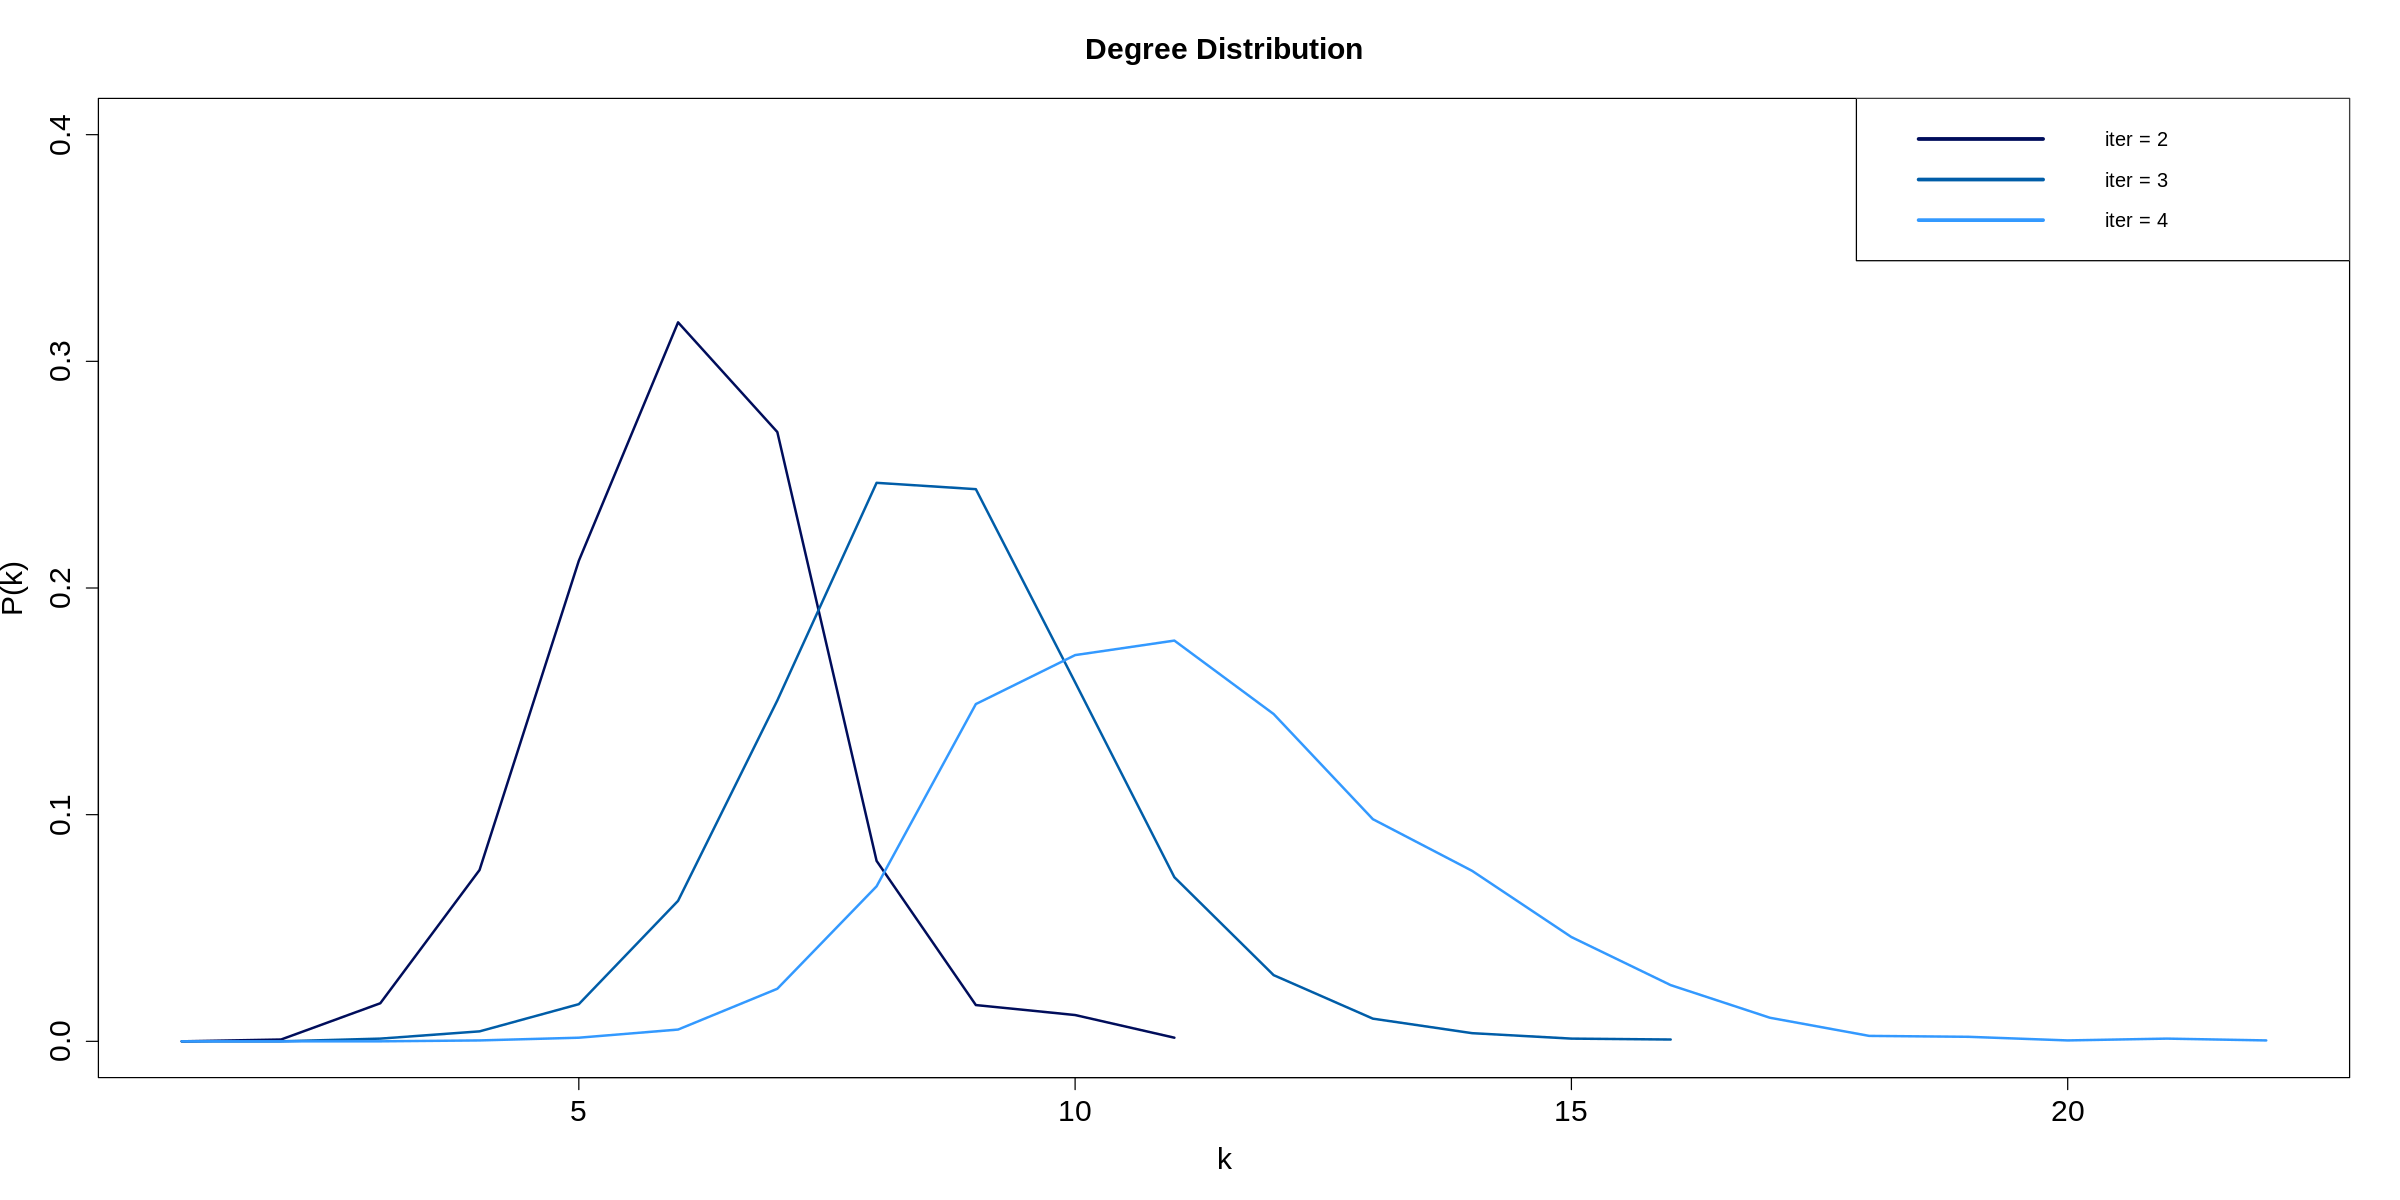

In [ ]:
#png("degree_distribution.png", width = 600, height = 600)

plot(1:length(k_AS_it4), k_AS_it4, type="n", ylim = c(0, 0.4), xlab = "k", ylab = "P(k)", cex.lab = 1.5, cex.axis=1.5, main="Degree Distribution", cex.main=1.5)
lines(1:length(k_AS_it2), k_AS_it2, col="#000D5B", pch=19, lwd = 2)
lines(1:length(k_AS_it3), k_AS_it3, col="#005DA8", pch=19, lwd = 2)
lines(1:length(k_AS_it4), k_AS_it4, col="#3399FF", pch=19, lwd = 2)

legend("topright", legend = c("iter = 2", "iter = 3", "iter = 4"), col = c("#000D5B", "#005DA8", "#3399FF"), lwd=3)

#dev.off()

In [ ]:
avg_rho_comunity<- function(N, repetitions, iterations, epochs, languages, model) {

  avg_interface <- list()
  for (i in 1:repetitions) {
    g <- comunity_structure_graph(N=N, languages = languages, iterations = iterations)
    results <- model(g, epochs = epochs)
    avg_interface[[i]] <- results$interface_density
  }
  average_results <- sapply(1:length(avg_interface[[1]]), function(i) mean(sapply(avg_interface, function(x) x[i])))
  return(unlist(average_results))
}



In [ ]:
# DO NOT RUN. TAKES A LOT OF TIME (USE THE CSV FILES INSTEAD)

repetitions <- 25
N <- 100
epochs <- 50000

avg_density_com_AS2 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 2, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_density_com_AS3 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 3, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_density_com_AS4 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 4, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)
avg_density_lat_AS <- avg_rho(N=N, iterations = repetitions, epochs=epochs, languages = c("A", "B"), AbramsStrogatz)

avg_density_com_Bi2 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 2, epochs=epochs, languages = c("A","AB", "B"), Billingual)
avg_density_com_Bi3 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 3, epochs=epochs, languages = c("A","AB", "B"), Billingual)
avg_density_com_Bi4 <- avg_rho_comunity(N=N, repetitions = repetitions, iterations = 4, epochs=epochs, languages = c("A","AB", "B"), Billingual)
avg_density_lat_Bi <- avg_rho(N=N, iterations = repetitions, epochs=epochs, languages = c("A","AB", "B"), Billingual)


In [ ]:
x <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))

avg_density_comunity <- data.frame(x = x, iter2_AS = avg_density_com_AS2, iter3_AS = avg_density_com_AS3, iter4_AS = avg_density_com_AS4, lat_AS = avg_density_lat_AS,
iter2_Bi = avg_density_com_Bi2, iter3_Bi = avg_density_com_Bi3, iter4_Bi = avg_density_com_Bi4, lat_Bi = avg_density_lat_Bi)

write.csv(avg_density_comunity, file = "iter_comunity.csv", row.names=FALSE)

In [ ]:
data <- read.csv("iter_comunity.csv")

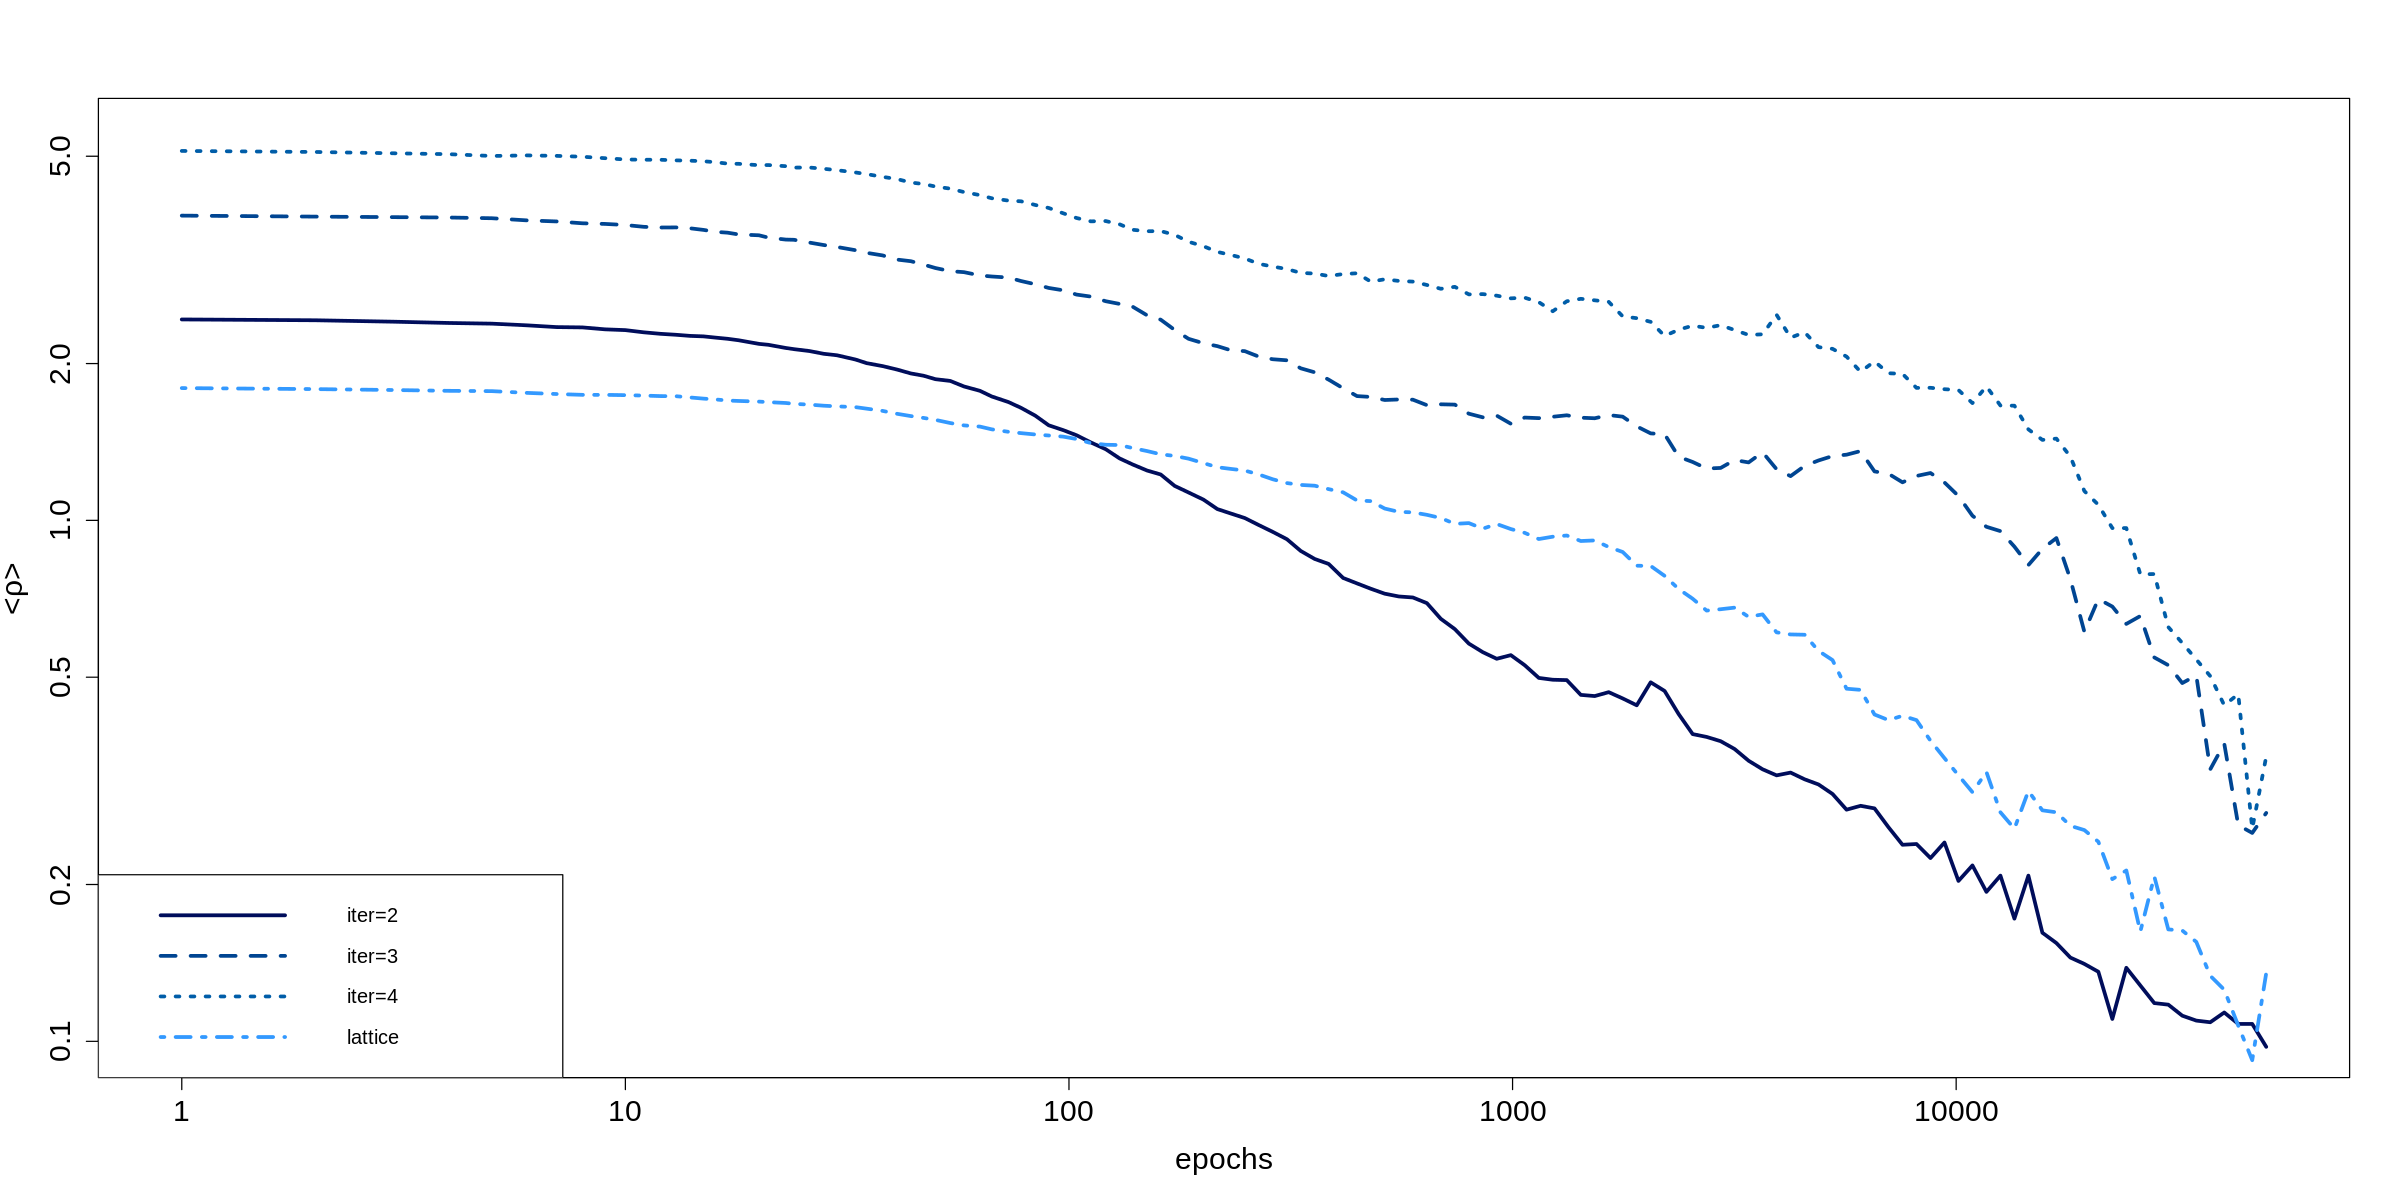

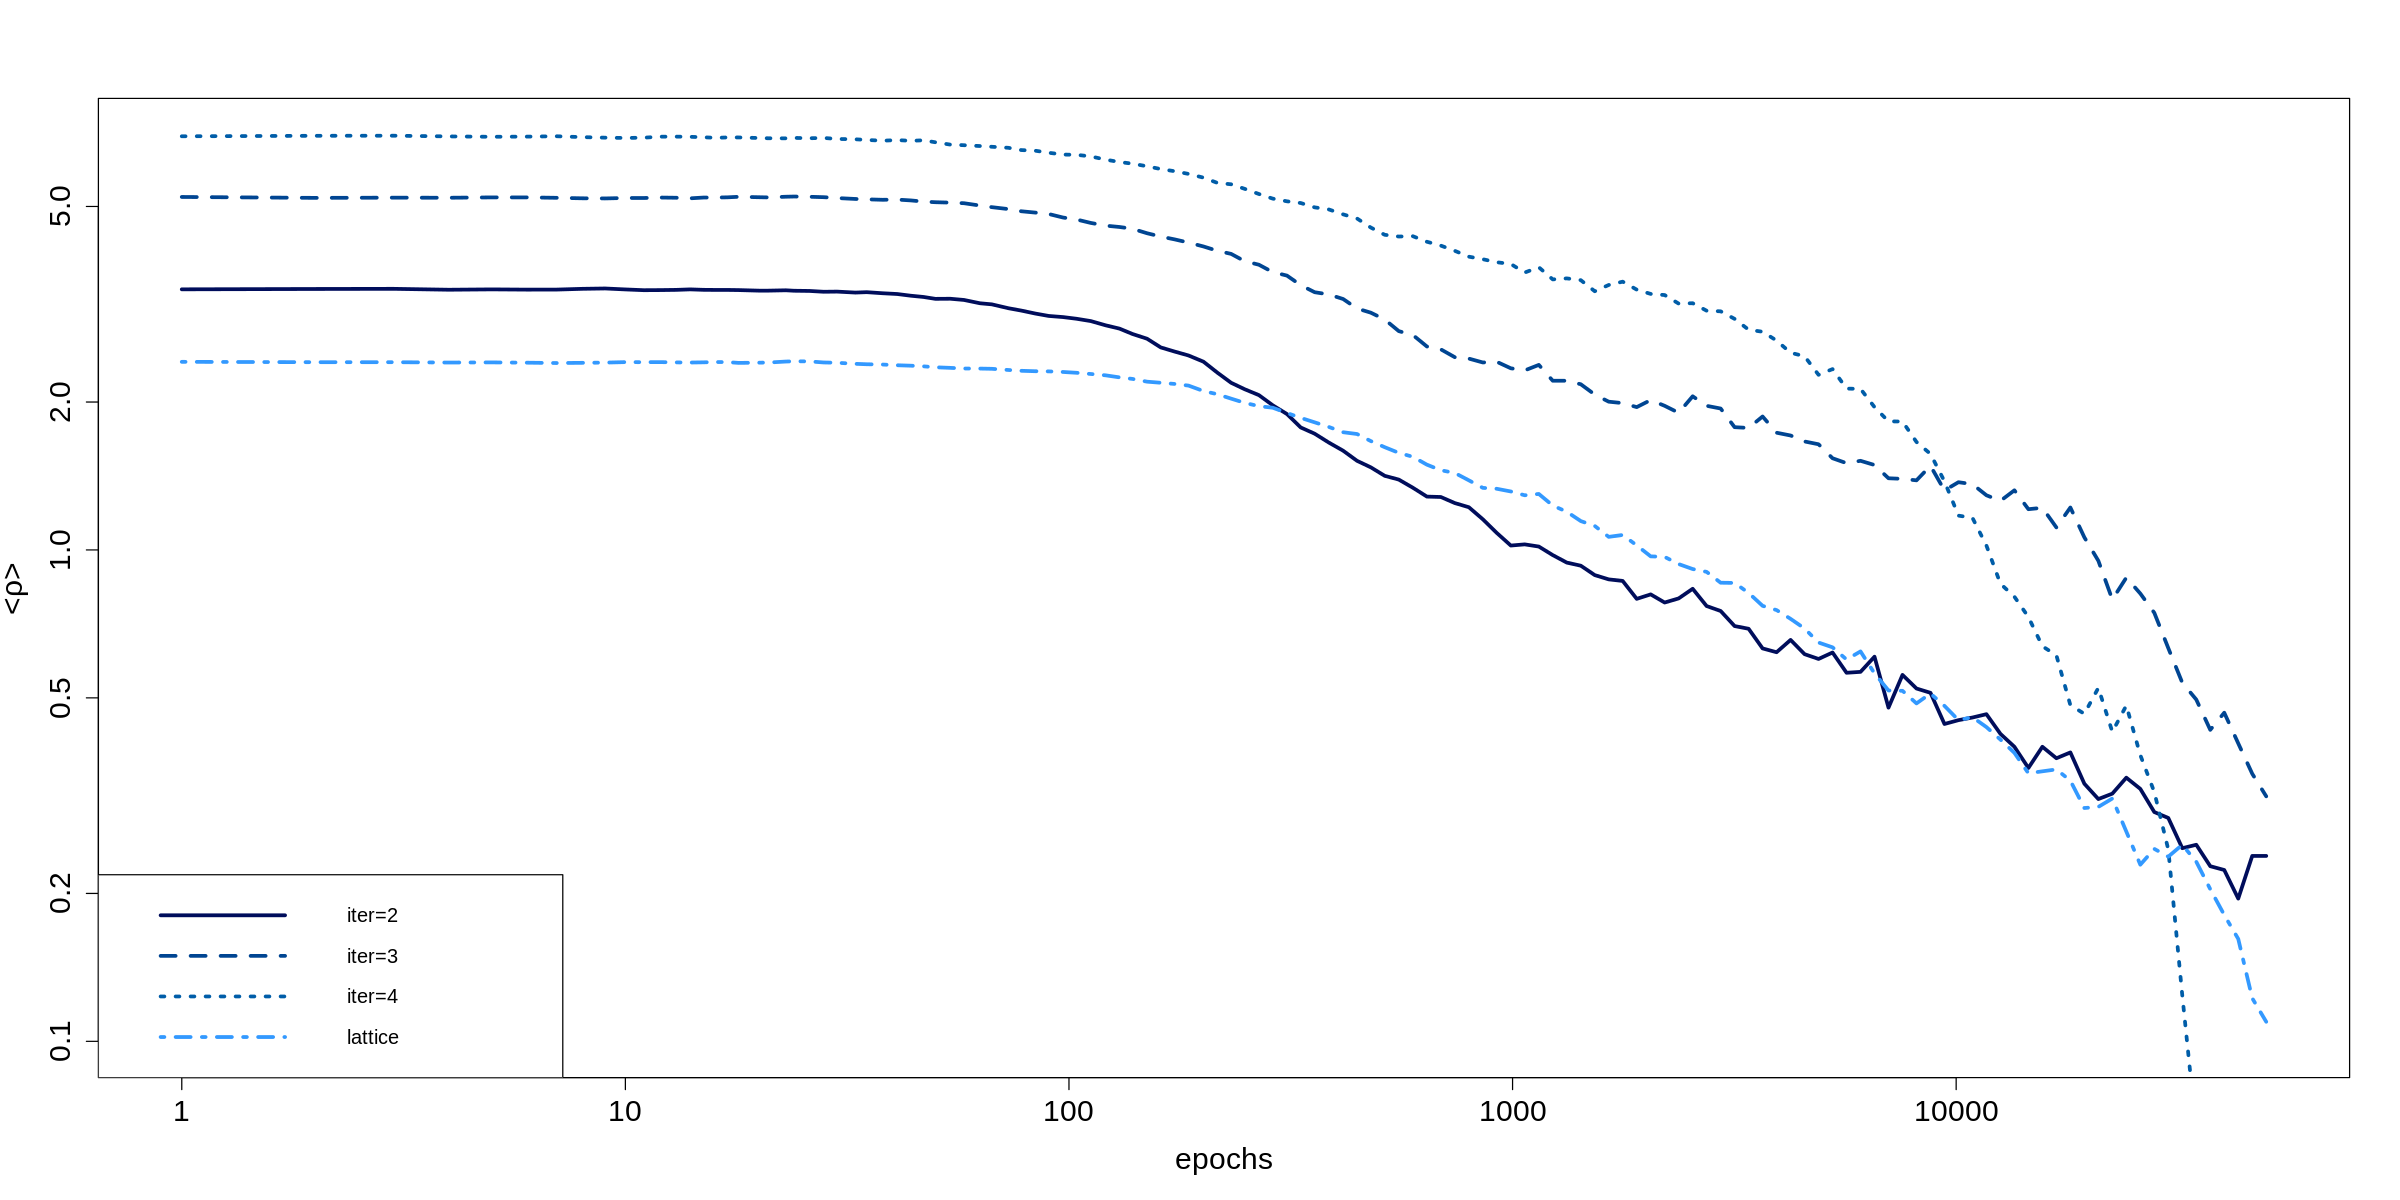

In [ ]:


#png("AS_comunity_structure.png", width = 600, height = 600)


plot(data$x[data$iter2_AS > 0], data$iter2_AS[data$iter2_AS > 0], type="n", log="xy", xlab = "epochs",
ylab="<ρ>", cex.lab = 1.5, cex.axis=1.5, ylim=c(0.1, 5.5))

lines(data$x[data$iter2_AS > 0], data$iter2_AS[data$iter2_AS > 0], lwd = 3, col= "#000D5B", lty=1)
lines(data$x[data$iter3_AS > 0], data$iter3_AS[data$iter3_AS > 0], lwd=3,  col= "#004592", lty=2)
lines(data$x[data$iter4_AS > 0], data$iter4_AS[data$iter4_AS > 0], lwd=3, col="#005DA8", lty=3)
lines(data$x[data$lat_AS > 0], data$lat_AS[data$lat_AS > 0], lwd=3, col= "#3399FF", lty=4)

legend("bottomleft", legend = c("iter=2", "iter=3", "iter=4", "lattice"),
       col = c("#000D5B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4))

#dev.off()

#png("Bi_comunity_structure.png", width = 600, height = 600)


plot(data$x[data$iter2_Bi > 0], data$iter2_Bi[data$iter2_Bi > 0], type="n", log="xy", xlab = "epochs",
ylab="<ρ>", cex.lab = 1.5, cex.axis=1.5, ylim=c(0.1, 7))

lines(data$x[data$iter2_Bi > 0], data$iter2_Bi[data$iter2_Bi > 0], lwd=3, col= "#000D5B", lty=1)
lines(data$x[data$iter3_Bi > 0], data$iter3_Bi[data$iter3_Bi > 0], lwd=3,  col= "#004592", lty=2)
lines(data$x[data$iter4_Bi > 0], data$iter4_Bi[data$iter4_Bi > 0], lwd=3, col="#005DA8", lty=3)
lines(data$x[data$lat_Bi > 0], data$lat_Bi[data$lat_Bi > 0], lwd=3, col= "#3399FF", lty=4)

legend("bottomleft", legend = c("iter=2", "iter=3", "iter=4", "lattice"),
       col = c("#000D5B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4))

#dev.off()

## Volatility and Prestige

We can consider the effects that prestige and volatility have for the Abrams-Strogatz model. Now the transition probabilities will be:

$$ p_{i, A->B} = (1 - s)(\sigma_i ^B)^a ~~~~~ p_{i, B->A} = s(\sigma_i ^A)^a $$

In [ ]:
# DO NOT RUN. TAKES A LOT OF TIME (USE THE CSV FILES INSTEAD)

epochs <- 50000
N <- 225
iterations <- 8

avg_rho<- function(N, iterations, epochs, languages, model, s=0.5, a=1) {

  avg_interface <- list()
  for (i in 1:iterations) {
    g <- lattice_graph(N=N, languages = languages)
    results <- model(g, epochs = epochs, a=a, s=s)
    avg_interface[[i]] <- results$interface_density
  }
  average_results <- sapply(1:length(avg_interface[[1]]), function(i) mean(sapply(avg_interface, function(x) x[i])))
  return(unlist(average_results))
}

avg_densitys01_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, s=0.1)
avg_densitys025_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, s=0.25)
avg_densitys05_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, s=0.5)
avg_densitys075_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, s=0.75)

avg_densitya01_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, a=0.1)
avg_densitya05_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, a=0.5)
avg_densitya1_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, a=1)
avg_densitya25_AS <- avg_rho(N=N, iterations = iterations, epochs=epochs, languages = c("A", "B"), AbramsStrogatz, a=2.5)



In [ ]:
avg_density_prs_vol<- data.frame(s01_AS = avg_densitys01_AS, s025_AS = avg_densitys025_AS, s05_AS = avg_densitys05_AS, s075_AS = avg_densitys075_AS,
a01_AS = avg_densitya01_AS, a05_AS = avg_densitya05_AS, a1_AS = avg_densitya1_AS, a25_AS = avg_densitya25_AS)

write.csv(avg_density_prs_vol, file = "prestige_volatility.csv", row.names=FALSE)

In [ ]:
data <- read.csv("prestige_volatility.csv")

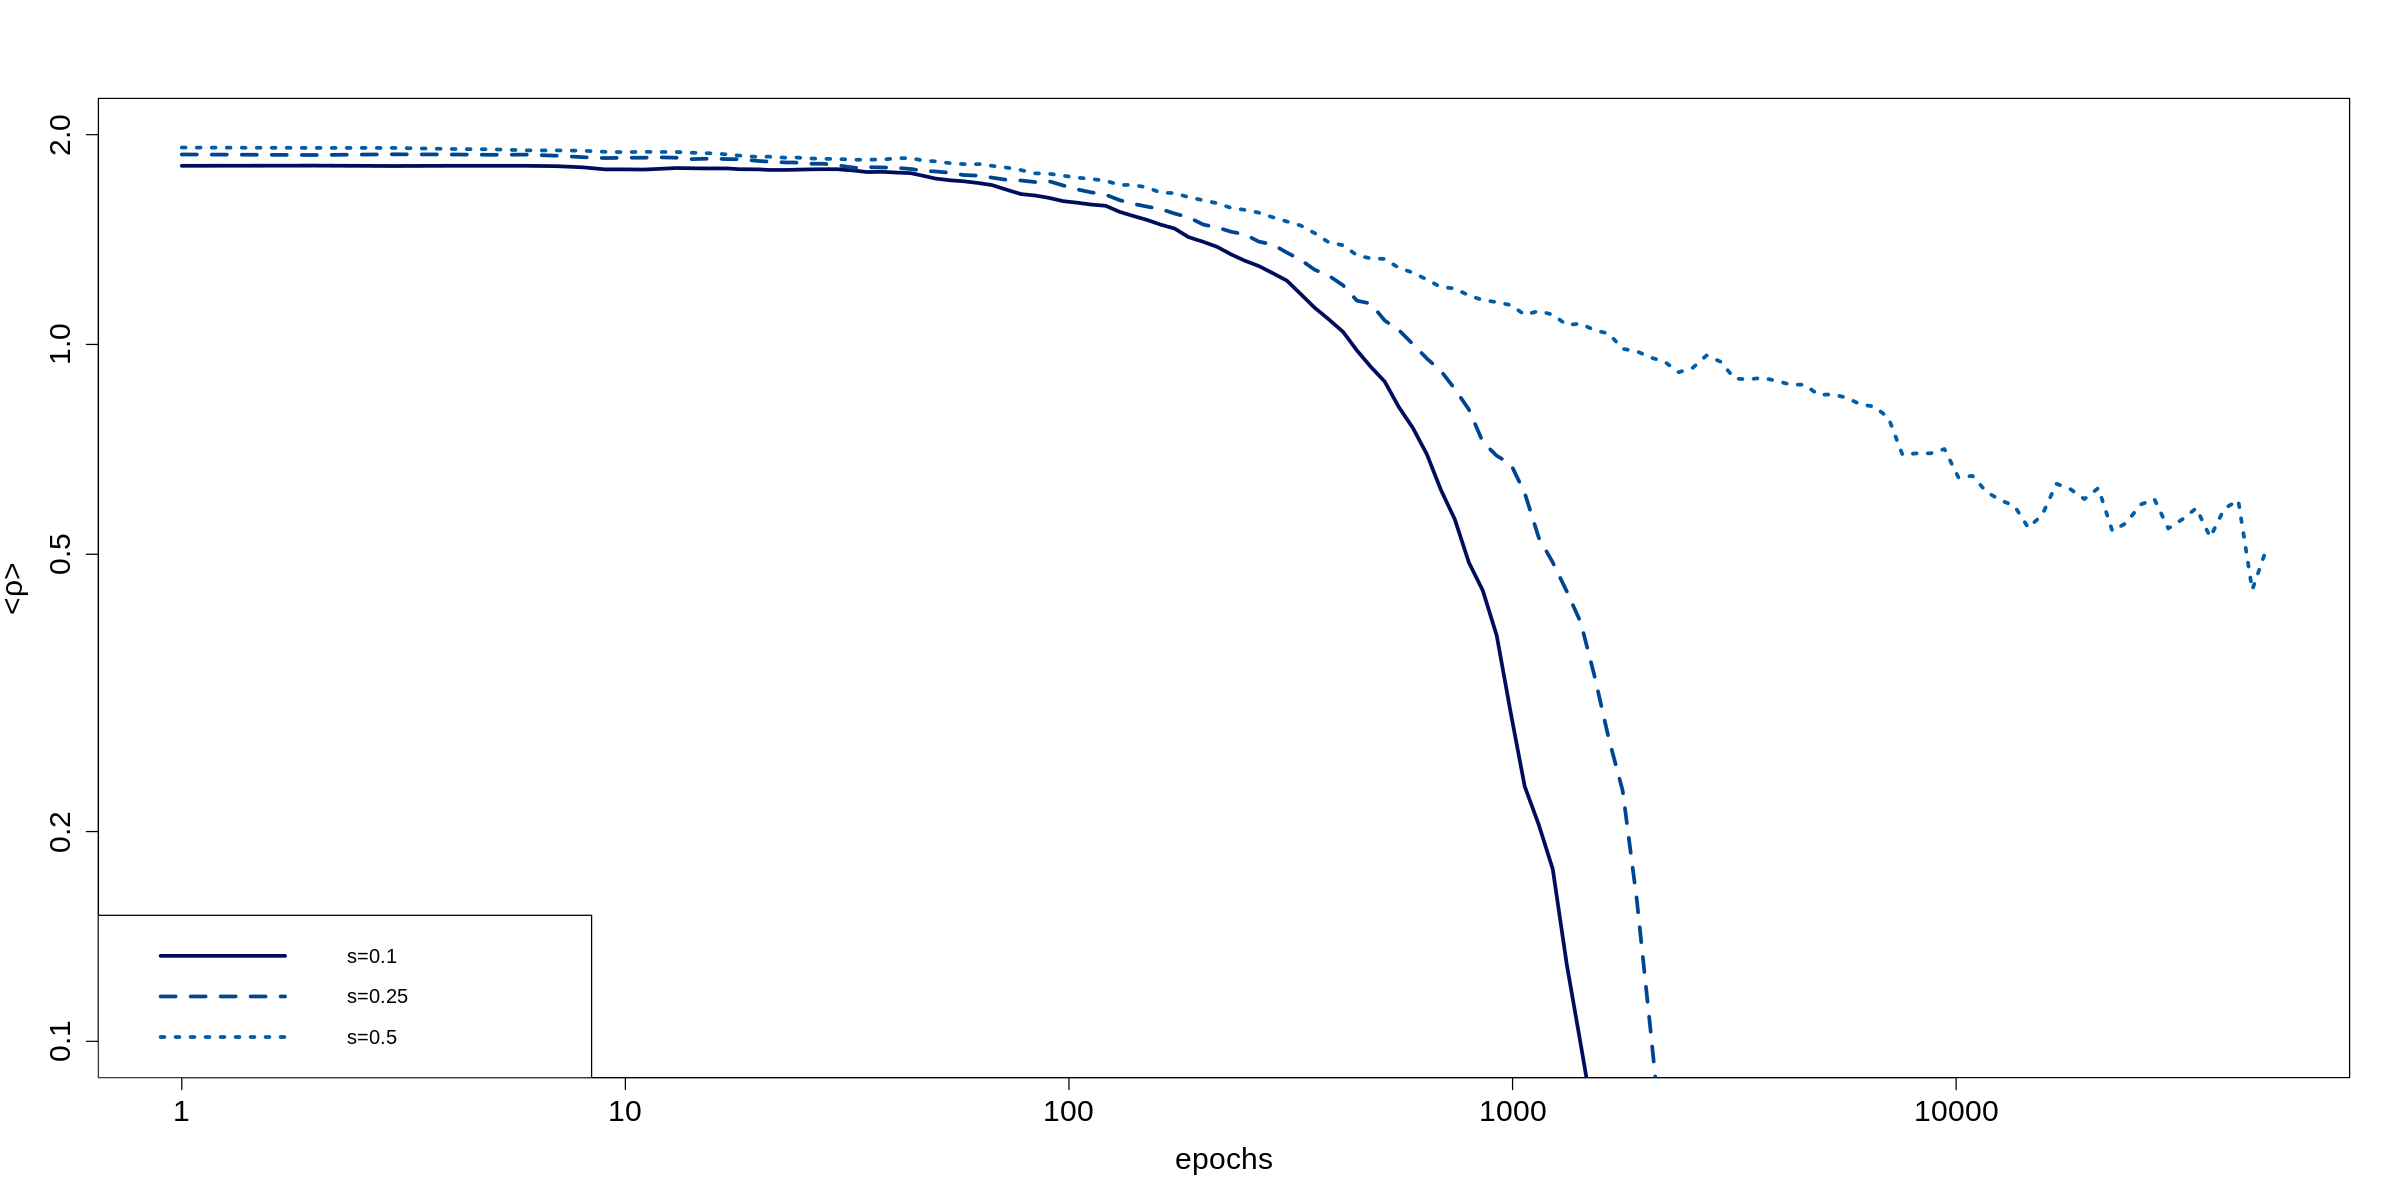

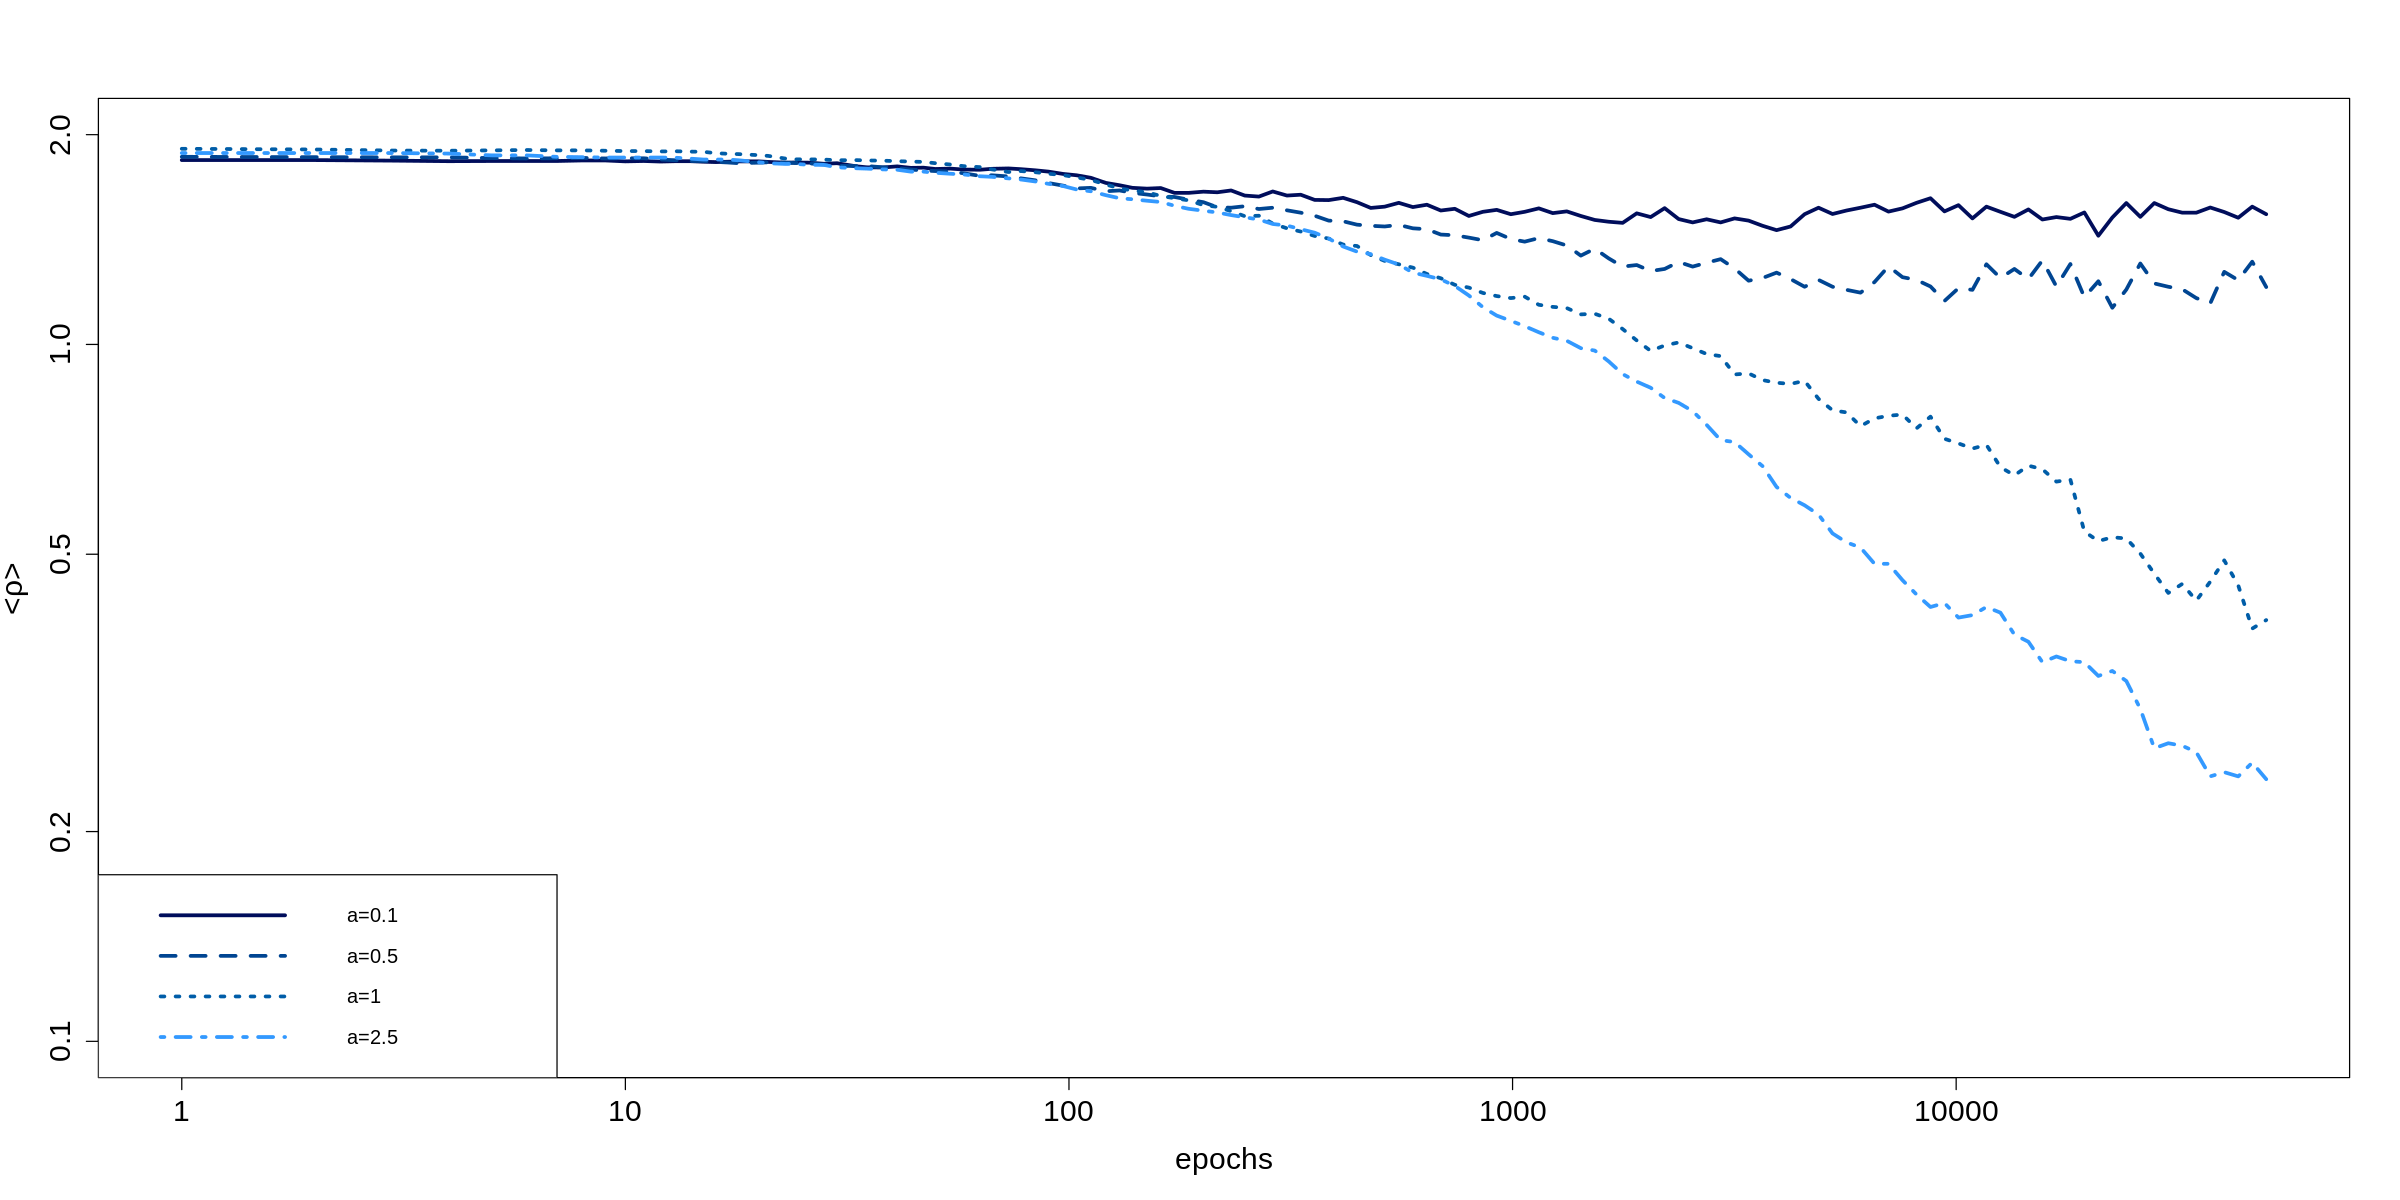

In [ ]:
epochs <- 50000
x <- unique(round(10^seq(0, to=log10(epochs), length.out = 150)))

#png("prestige.png", width = 600, height = 600)

plot(x[data$s01_AS>0], data$s01_AS[data$s01_AS>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$s01_AS>0], data$s01_AS[data$s01_AS>0], lwd=3, lty=1, col= "#000D5B")
lines(x[data$s025_AS>0], data$s025_AS[data$s025_AS>0], lwd=3, lty=2, col= "#004592")
lines(x[data$s05_AS>0], data$s05_AS[data$s05_AS>0], lwd=3, lty=3, col= "#005DA8")
#lines(x[data$s075_AS>0], data$s075_AS[data$s075_AS>0], lwd=3, lty=4, col="#3399FF")

legend("bottomleft", legend = c("s=0.1", "s=0.25", "s=0.5"),
       col = c("#000D5B", "#004592", "#005DA8"), lwd = 3, lty = c(1, 2, 3))

#dev.off()

#png("volatility.png", width = 600, height = 600)

plot(x[data$a01_AS>0], data$a01_AS[data$a01_AS>0], xlim = c(1, 50000), xlab = "epochs", ylab = "<ρ>", ylim = c(0.1, 2), type = "n", log="xy", cex.lab=1.5, cex.axis=1.5)
lines(x[data$a01_AS>0], data$a01_AS[data$a01_AS>0], lwd=3, lty=1, col= "#000D5B")
lines(x[data$a05_AS>0], data$a05_AS[data$a05_AS>0], lwd=3, lty=2, col= "#004592")
lines(x[data$a1_AS>0], data$a1_AS[data$a1_AS>0], lwd=3, lty=3, col= "#005DA8")
lines(x[data$a25_AS>0], data$a25_AS[data$a25_AS>0], lwd=3, lty=4, col="#3399FF")

legend("bottomleft", legend = c("a=0.1", "a=0.5", "a=1", "a=2.5"),
       col = c("#000D5B", "#004592", "#005DA8", "#3399FF"), lwd = 3, lty = c(1, 2, 3, 4))

#dev.off()

In [ ]:
data <- cbind(x, data)

gamma_s01_AS <- as.numeric(-coef(lm(log(s01_AS[s01_AS > 0]) ~ log(x[s01_AS > 0]), data=data))[2])
gamma_s025_AS <-as.numeric(-coef(lm(log(s025_AS[s025_AS > 0]) ~ log(x[s025_AS > 0]), data=data))[2])
gamma_s05_AS <-as.numeric(-coef(lm(log(s05_AS[s05_AS > 0]) ~ log(x[s05_AS > 0]), data=data))[2])

gamma_a01_AS <- as.numeric(-coef(lm(log(a01_AS[a01_AS > 0]) ~ log(x[a01_AS > 0]), data=data))[2])
gamma_a05_AS <-as.numeric(-coef(lm(log(a05_AS[a05_AS > 0]) ~ log(x[a05_AS > 0]), data=data))[2])
gamma_a1_AS <-as.numeric(-coef(lm(log(a1_AS[a1_AS > 0]) ~ log(x[a1_AS > 0]), data=data))[2])
gamma_a25_AS <-as.numeric(-coef(lm(log(a25_AS[a25_AS > 0]) ~ log(x[a25_AS > 0]), data=data))[2])



In [ ]:
coeff_prestige <- data.frame(Prestige = c(0.1, 0.25, 0.5), Abrams_Strogatz = c(gamma_s01_AS, gamma_s025_AS, gamma_s05_AS))
coeff_volatility <- data.frame(Volatility = c(0.1, 0.5, 1, 2.5),
Abrams_Strogatz = c(gamma_a01_AS, gamma_a05_AS, gamma_a1_AS, gamma_a25_AS))

head(coeff_prestige)
head(coeff_volatility)

,Prestige,Abrams_Strogatz
,<dbl>,<dbl>
1,0.10,0.5341752
2,0.25,0.5509332
3,0.50,0.1555834


,Volatility,Abrams_Strogatz
,<dbl>,<dbl>
1,0.1,0.02450600
2,0.5,0.05734852
3,1.0,0.16112298
4,2.5,0.22894684


## LANGUAGE DEATH DYNAMICS

### DATA ADQUISITION

In order to get a better understanding of language models we have gather some data about bilingual comunities and see the evolution of the minority language through time. The data chosen was the share of speakers of Welsh, Gaellic Scottish, Irish and French in Wales, the county of Sutherland, Scotland, Ireland and Quebec respectively.

In doing so we aim to fit the Abrams-Strogratz model to our data and get the parameters a and s that explain the unbalance between two languages in a billingual comunity.

In [ ]:
# Welsh in Wales

Year_w <- c(1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971, 1981, 1991, 2001, 2011)
speakers_w <- c(0.545, 0.499, 0.435, 0.371, 0.368, 0.289, 0.26, 0.209, 0.187, 0.186, 0.208, 0.19)
welsh <- data.frame(Year=Year_w, speakers=speakers_w)


# Irish in Ireland (32 counties)

Year_i <- c(1821, 1835, 1841, 1851, 1861, 1871, 1891, 1901, 1911)
speakers_i <- c(0.550, 0.514, 0.506, 0.233, 0.191, 0.151, 0.145, 0.144, 0.133)
irish <- data.frame(Year=Year_i, speakers=speakers_i)

# Gaelic Scottish in Sutherland, Scotland

Year_g <- c(1881, 1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971)
speakers_g <- c(0.804, 0.771, 0.7175, 0.6175, 0.5225, 0.4405, 0.2526, 0.1883, 0.1451)
gaellic <- data.frame(Year=Year_g, speakers=speakers_g)

### Model Building

The model is given by the following:

$$ \dfrac {dx} {dt} = (1 - x)· P_{yx} (x, s) - x·P_{xy} (x, s)  $$

Assuming transition functions as:

$$ P_{yx} (x, s) = c · x^a ~~~~~  P_{xy} (x, s) = c·(1 -x)^a · (1 - s)     $$


In [ ]:
#diff equation

dxdt <- function (t, x, params) {
    c <- params$c
    s <- params$s
    a <- params$a

    result <- (1 - x)*c*x^a - x*c*((1 - x)^a)*(1 -s)
    return(list(result))
}


### FITTING THE DATA

#### WELSH (WALES)

In [ ]:
residual = function(params) {

    cinit = welsh$speakers[1]
    t = welsh$Year

    c <- params[1]
    s <- params[2]
    a <- params[3]

    out=ode(y=cinit, times=t, func=dxdt, parms=list(c=c, s=s, a=a), method="lsoda")
    outdf <- data.frame(out)
    colnames(outdf) <- c("Year", "speakers")


    res <- (outdf$speakers - welsh$speakers)

    return(res)

}

#initial params
parms = c(c=0, s=0.5, a=1)
fitval_w = nls.lm(parms, fn=residual, control = nls.lm.control(maxfev=50))

In [ ]:
fit_param <- fitval_w$par
t <- seq(from = 1891, to = 2011, by = 1)
cinit <- welsh$speakers[1]
pred_w <- ode(y=cinit, times=t, func=dxdt, parms=as.list(fit_param), method="lsoda")
colnames(pred_w) <- c("Year", "speakers")

#### IRISH (IRELAND, 32 COUNTIES)

In [ ]:
residual = function(params) {

    cinit = irish$speakers[1]
    t = irish$Year

    c <- params[1]
    s <- params[2]
    a <- params[3]

    out=ode(y=cinit, times=t, func=dxdt, parms=list(c=c, s=s, a=a), method="lsoda")
    outdf <- data.frame(out)
    colnames(outdf) <- c("Year", "speakers")


    res <- -(outdf$speakers - irish$speakers)

    return(res)

}

parms = c(c=0, s=0.5, a=1)
fitval_i = nls.lm(parms, fn=residual, control = nls.lm.control(maxfev=50))


In [ ]:
fit_param <- fitval_i$par
t <- seq(from = 1821, to = 1911, by = 1)
cinit <- irish$speakers[1]
pred_i <- ode(y=cinit, times=t, func=dxdt, parms=as.list(fit_param), method="lsoda")
colnames(pred_i) <- c("Year", "speakers")

#### GAELLIC SCOTTISH (COUNTY OF SUTHERLAND, SCOTLAND)

In [ ]:
residual = function(params) {

    cinit = gaellic$speakers[1]
    t = gaellic$Year

    c <- params[1]
    s <- params[2]
    a <- params[3]

    out=ode(y=cinit, times=t, func=dxdt, parms=list(c=c, s=s, a=a), method="lsoda")
    outdf <- data.frame(out)
    colnames(outdf) <- c("Year", "speakers")


    res <- -(outdf$speakers - gaellic$speakers)

    return(res)

}

parms = c(c=0, s=0.5, a=1)
fitval_g = nls.lm(parms, fn=residual, control = nls.lm.control(maxfev=50))


In [ ]:
fit_param <- fitval_g$par
t <- seq(from = 1881, to = 1971, by = 1)
cinit <- gaellic$speakers[1]
pred_g <- ode(y=cinit, times=t, func=dxdt, parms=as.list(fit_param), method="lsoda")
colnames(pred_g) <- c("Year", "speakers")

In [ ]:
data.frame(Welsh=fitval_w$par, Irish=fitval_i$par, Gaelic_Scottish=fitval_g$par)

,Welsh,Irish,Gaelic_Scottish
,<dbl>,<dbl>,<dbl>
c,-0.06003311,-0.04690999,-0.1173427
s,0.45288227,0.89898311,0.2961343
a,1.24522900,1.27393561,0.9493619


## PLOTTING THE FIT OF THE DATA

In [ ]:
plot_fit <- function(pred_data, exp_data) {

    p <- ggplot() +
        geom_line(data=as.data.frame(pred_data), aes(x=Year, y=speakers), color="blue4", linewidth=2) +
        geom_point(data=exp_data, aes(x=Year, y=speakers), size=4, color="cyan4") +
        labs(x="Year", y="Share of Population") +
        theme(plot.title=element_text(size=16, hjust = 0.5),
              axis.title = element_text(size=14), axis.text=element_text(size=12))
}


TableGrob (2 x 2) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]


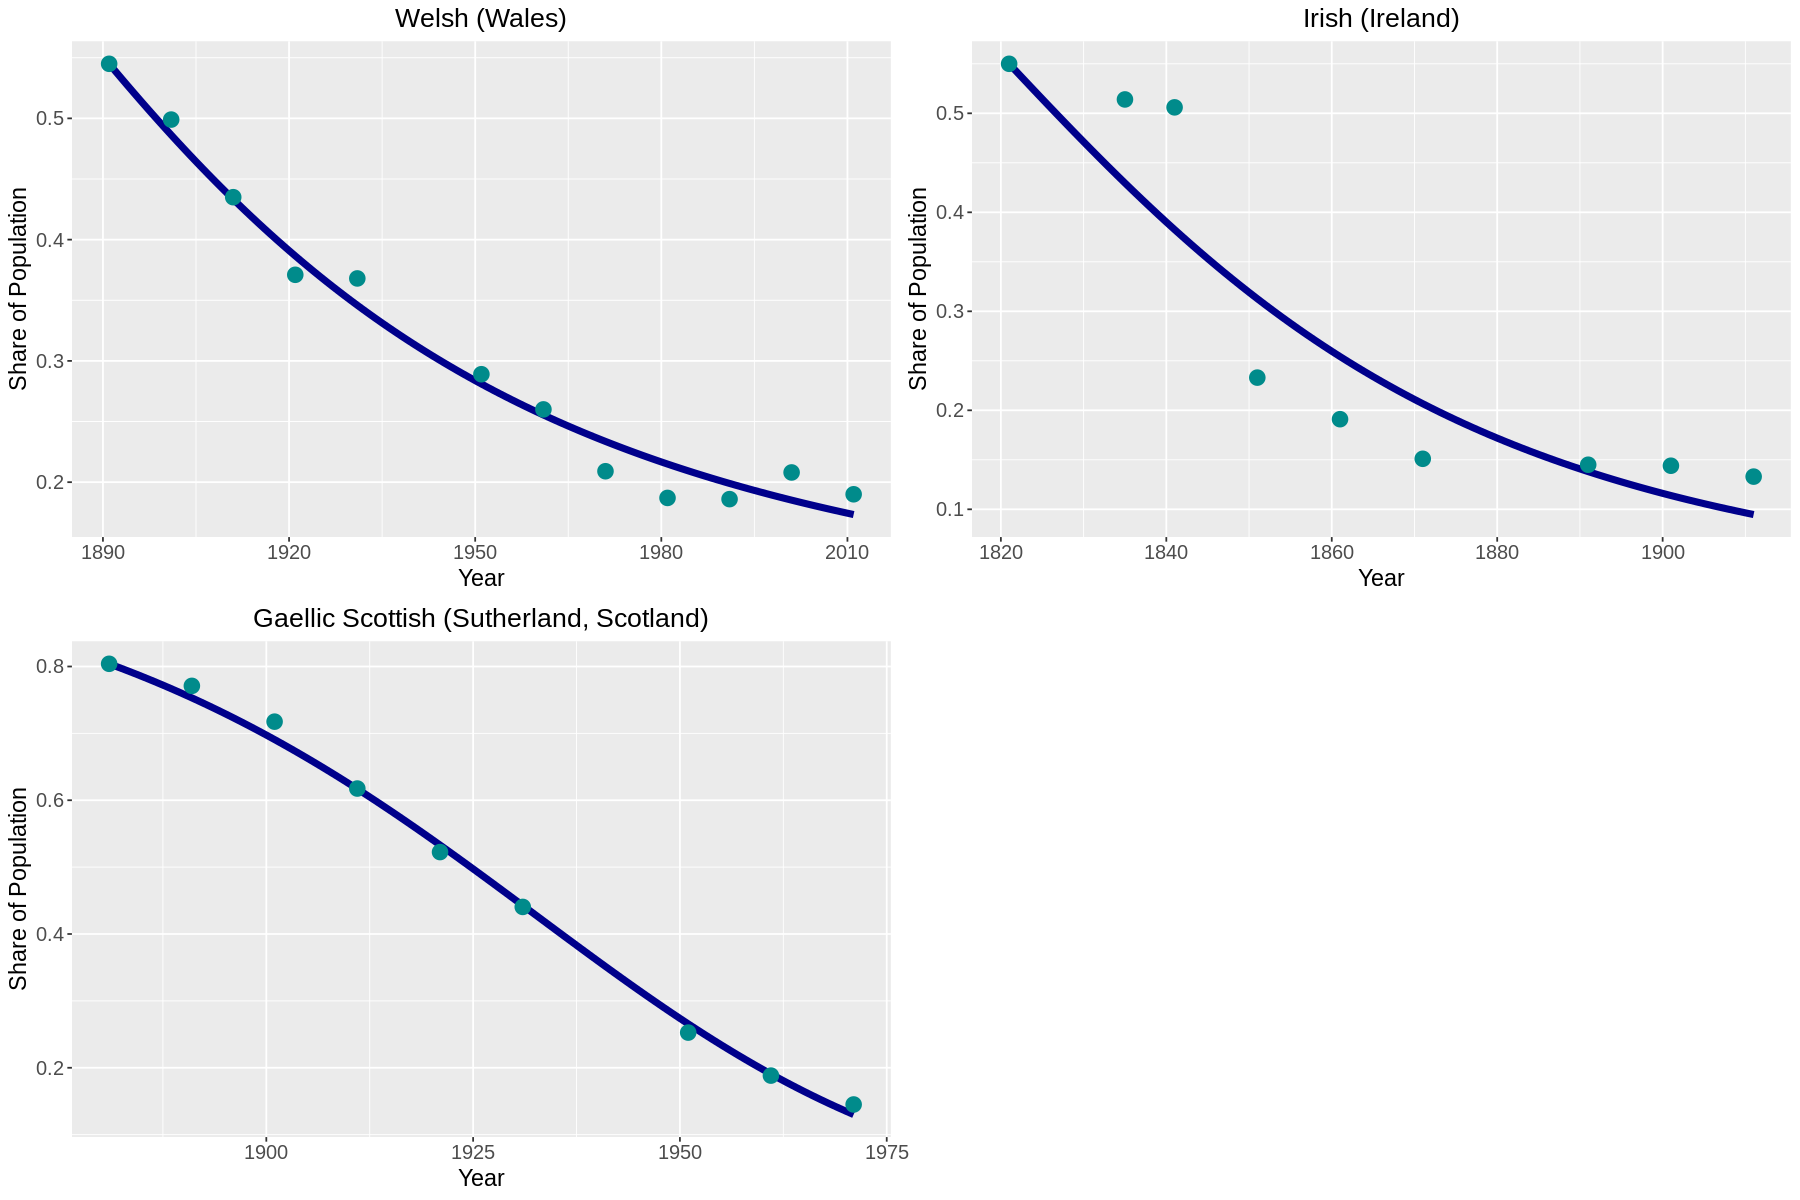

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
par(mfrow=c(2, 2))

p1 <- plot_fit(pred_w, welsh) + ggtitle("Welsh (Wales)")
p2 <- plot_fit(pred_i, irish) + ggtitle("Irish (Ireland)")
p3 <- plot_fit(pred_g, gaellic) + ggtitle("Gaellic Scottish (Sutherland, Scotland)")

grid <- grid.arrange(p1, p2, p3, ncol = 2)
print(grid)

In [ ]:
ggsave("fitted_data.png", plot = grid, width = 15, height = 11)